GJ4102: G140L spectra redone by STScI, G140M specta need re-exracting

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d

import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from matplotlib.gridspec import GridSpec


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
path = '/media/david/2tb_ext_hd/hddata/meats/hst/gj4102/'
stsci_path = '{}16701_07/data/'.format(path) #some data was redone by stsci.
st_x1ds = glob.glob('{}*x1d.fits'.format(stsci_path))
st_x1ds

['/media/david/2tb_ext_hd/hddata/meats/hst/gj4102/16701_07/data/oeoo07010_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/gj4102/16701_07/data/oeoo07020_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/gj4102/16701_07/data/oeoo07030_x1d.fits']

/media/david/2tb_ext_hd/hddata/meats/hst/gj4102/16701_07/data/oeoo07010_x1d.fits
G140L
82.32629


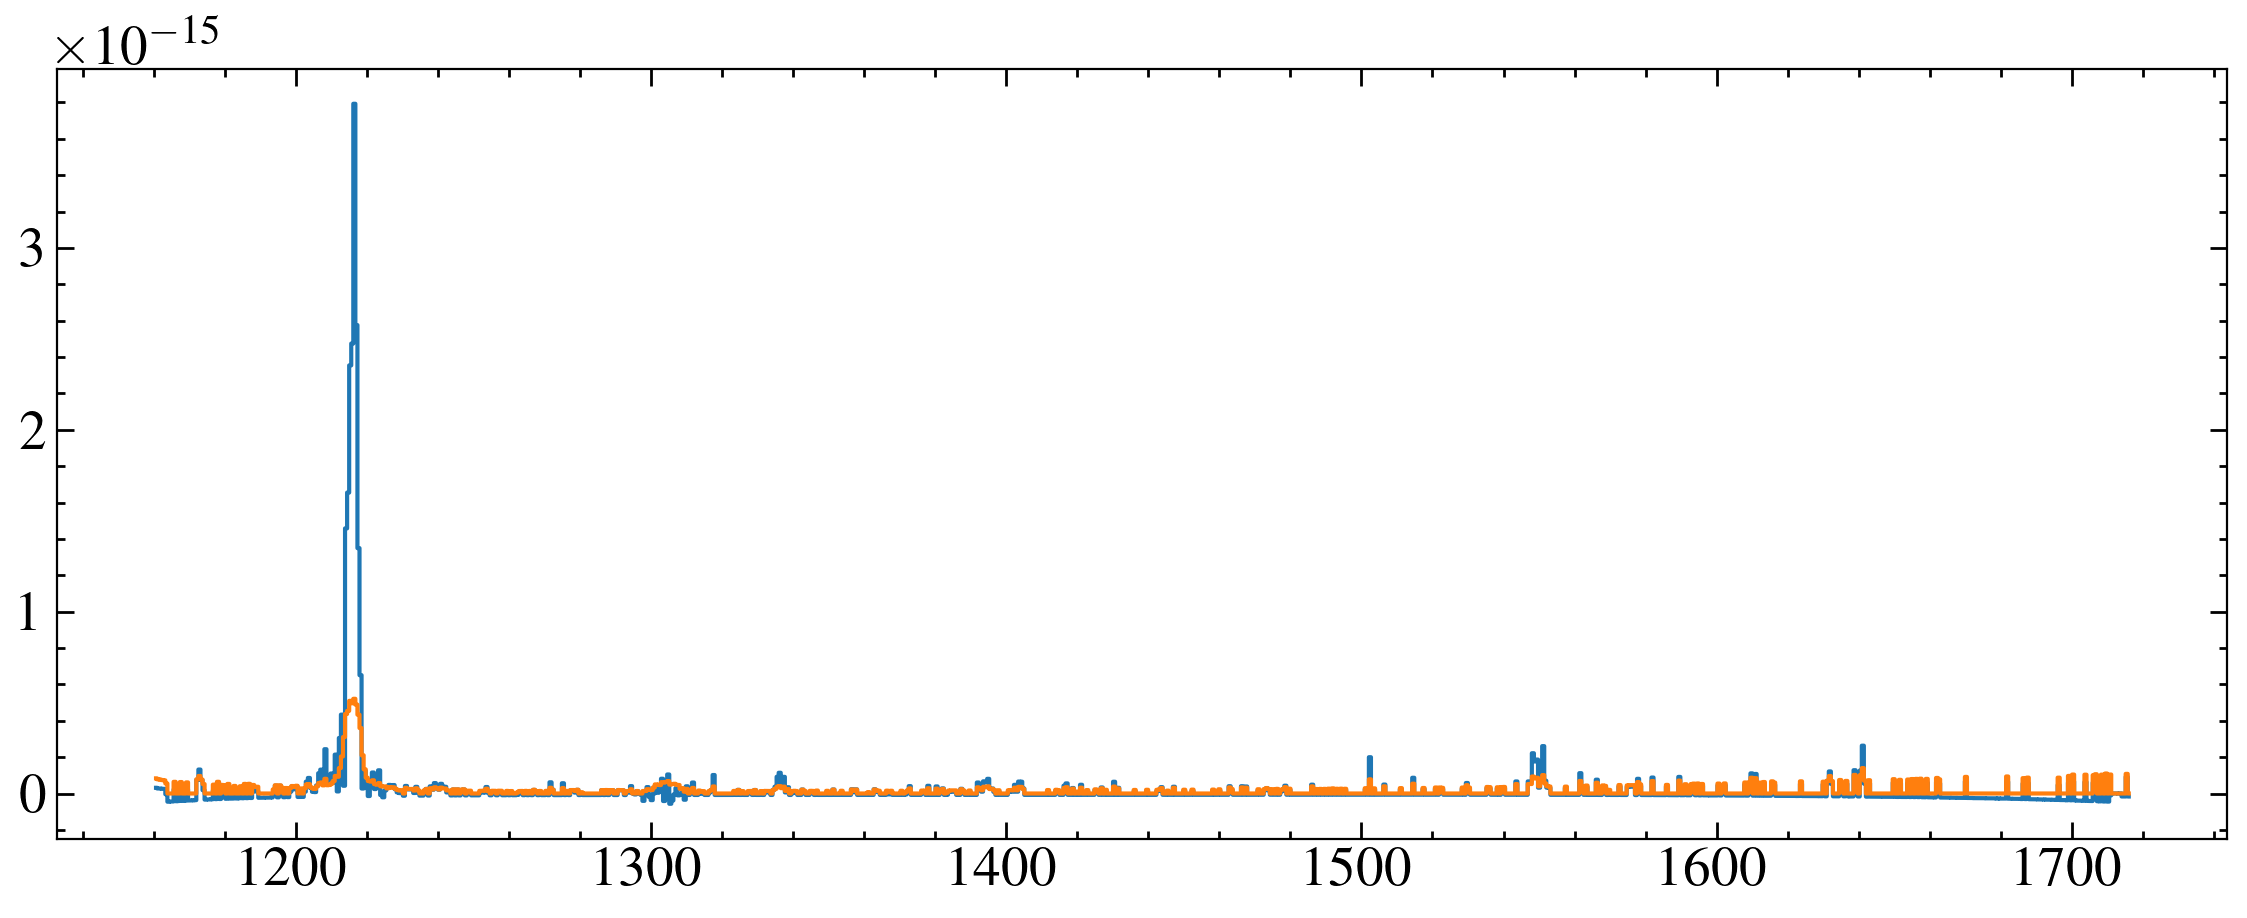

/media/david/2tb_ext_hd/hddata/meats/hst/gj4102/16701_07/data/oeoo07020_x1d.fits
G140L
82.42636


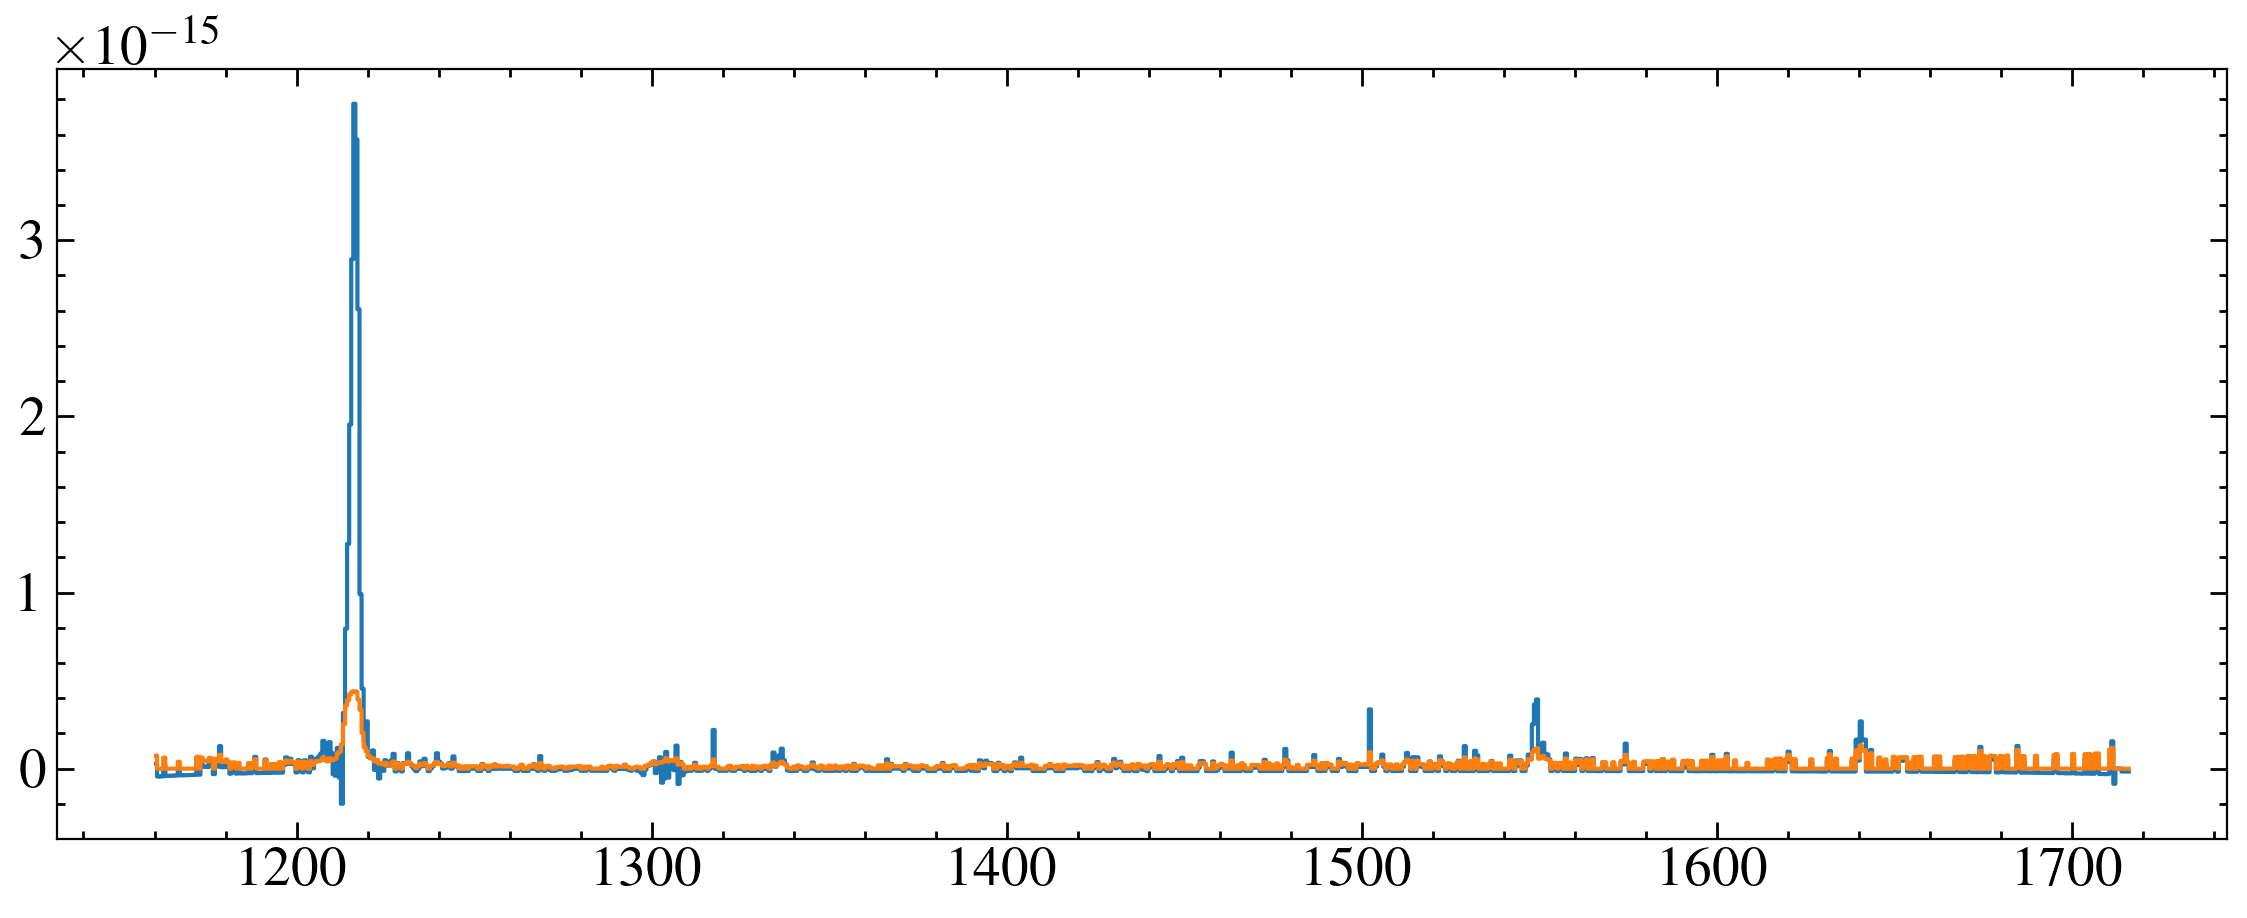

/media/david/2tb_ext_hd/hddata/meats/hst/gj4102/16701_07/data/oeoo07030_x1d.fits
G140L
83.107735


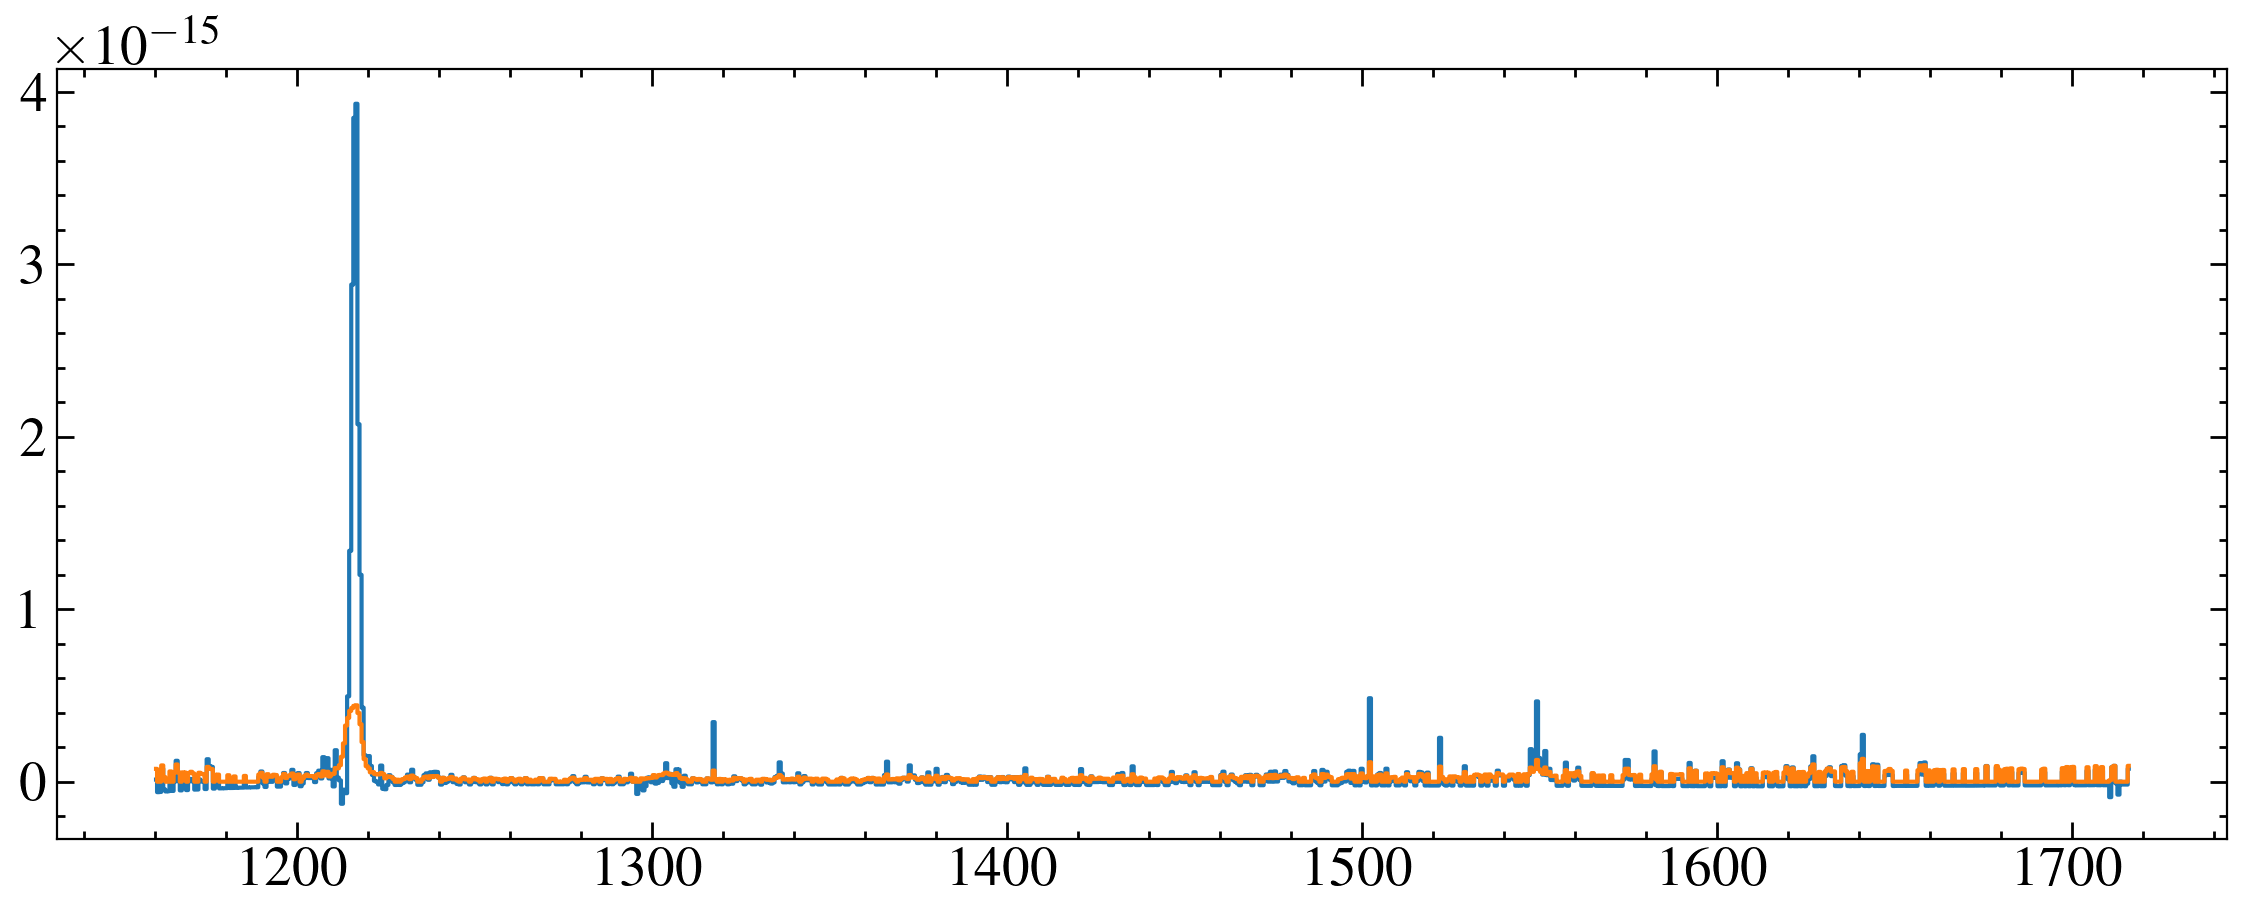

In [3]:
for x in st_x1ds:
    print(x)
    grating = fits.getheader(x, 0)['OPT_ELEM'] 
    print(grating)
    data = fits.getdata(x, 1)[0]
    print(data['A2Center'])
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    if grating in ['G140M', 'G140L']:
        mask = (w > 1160)
        
        # plt.ylim(-1e-16, 1e-16)
        # plt.axhline(0, ls='--', c='0.5')
    # if grating =='G230L':
    #     mask = (w > 1700)
    # if grating =='G430L':
    #     mask = (w > 3000)
    
    w, f, e = w[mask], f[mask], e[mask]
    plt.step(w, f, where='mid')
    plt.step(w, e, where='mid')
    plt.show()
    

In [4]:
import stistools
os.environ['oref'] = path

The following tasks in the stistools package can be run with TEAL:
   basic2d      calstis     ocrreject     wavecal        x1d          x2d


/home/david/anaconda3/envs/stenv/lib/python3.11/site-packages/stsci/tools/nmpfit.py:8: UserWarning: NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.
  warnings.warn("NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.")
/home/david/anaconda3/envs/stenv/lib/python3.11/site-packages/stsci/tools/gfit.py:18: UserWarning: GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it.Use astropy.modeling instead.
  warnings.warn("GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it."


In [5]:
def build_trace_grid(SPTRCTAB, grating, cenwave):
    """
    Extends a grid of trace displacements to cover all y positions
    """
    data = fits.getdata(SPTRCTAB, 1)
    tracedata = data[(data['OPT_ELEM']==grating) & (data['CENWAVE'] == cenwave)]
    all_y = np.arange(len(tracedata[0]['A2DISPL']))
    grid = interp1d(tracedata['A2CENTER'], tracedata['A2DISPL'], axis=0, fill_value='extrapolate')(all_y)
    tracegrid = [a+b for a, b in zip(grid, all_y)] 
    return tracegrid
    
def get_a2center(x, y, tracegrid):
    """
    get the trace a2center at a1center
    """
    xcol = np.array(tracegrid)[:,int(x)]
    xind = (np.abs(xcol - y)).argmin()
    a2center = xind + 1 #calstis is 1-indexed 
    return a2center

In [6]:
roots = ['oeoo08010', 'oeoo08020', 'oeoo08030']


oeoo08010
159
oeoo08020
159
oeoo08030
160
reextractions/gj4102/oeoo09010_new_x1d.fits
G230L
532.8642


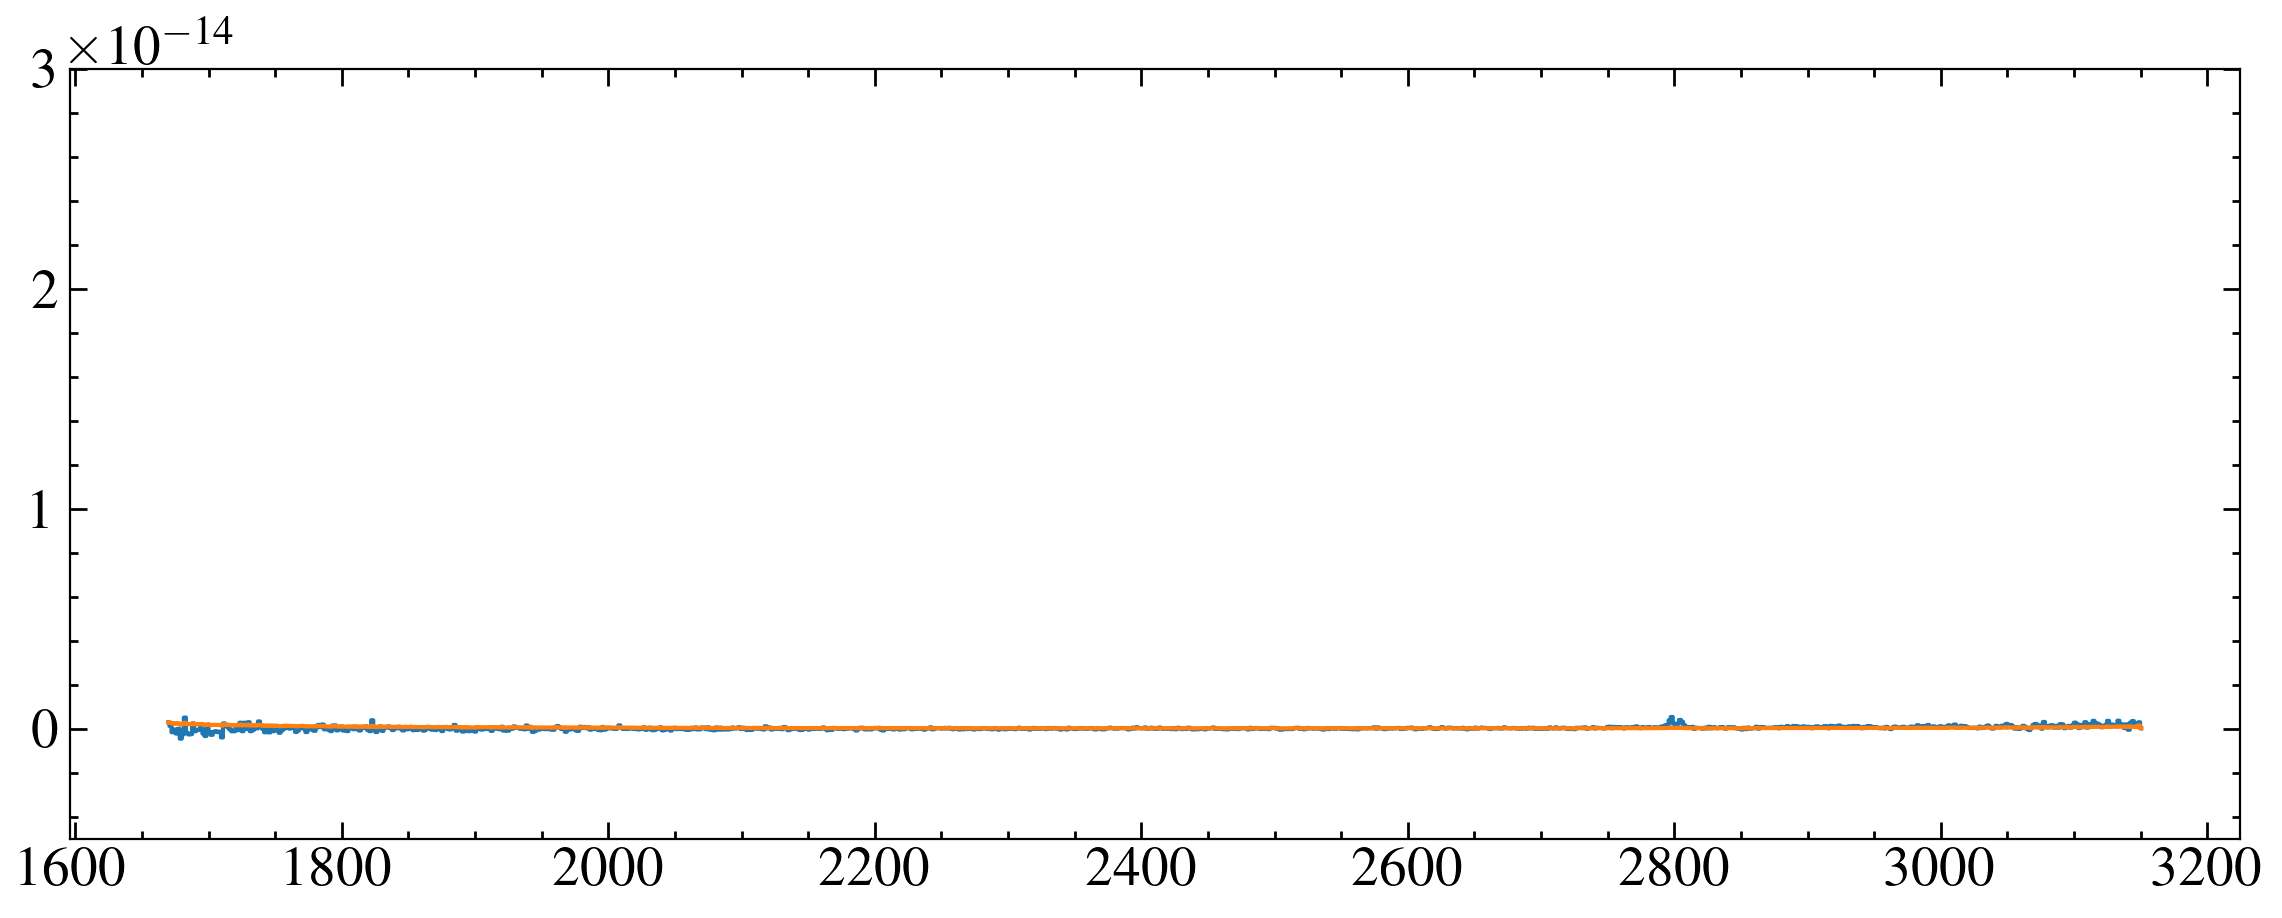

reextractions/gj4102/oeoo09020_new_x1d.fits
G230L
533.0787


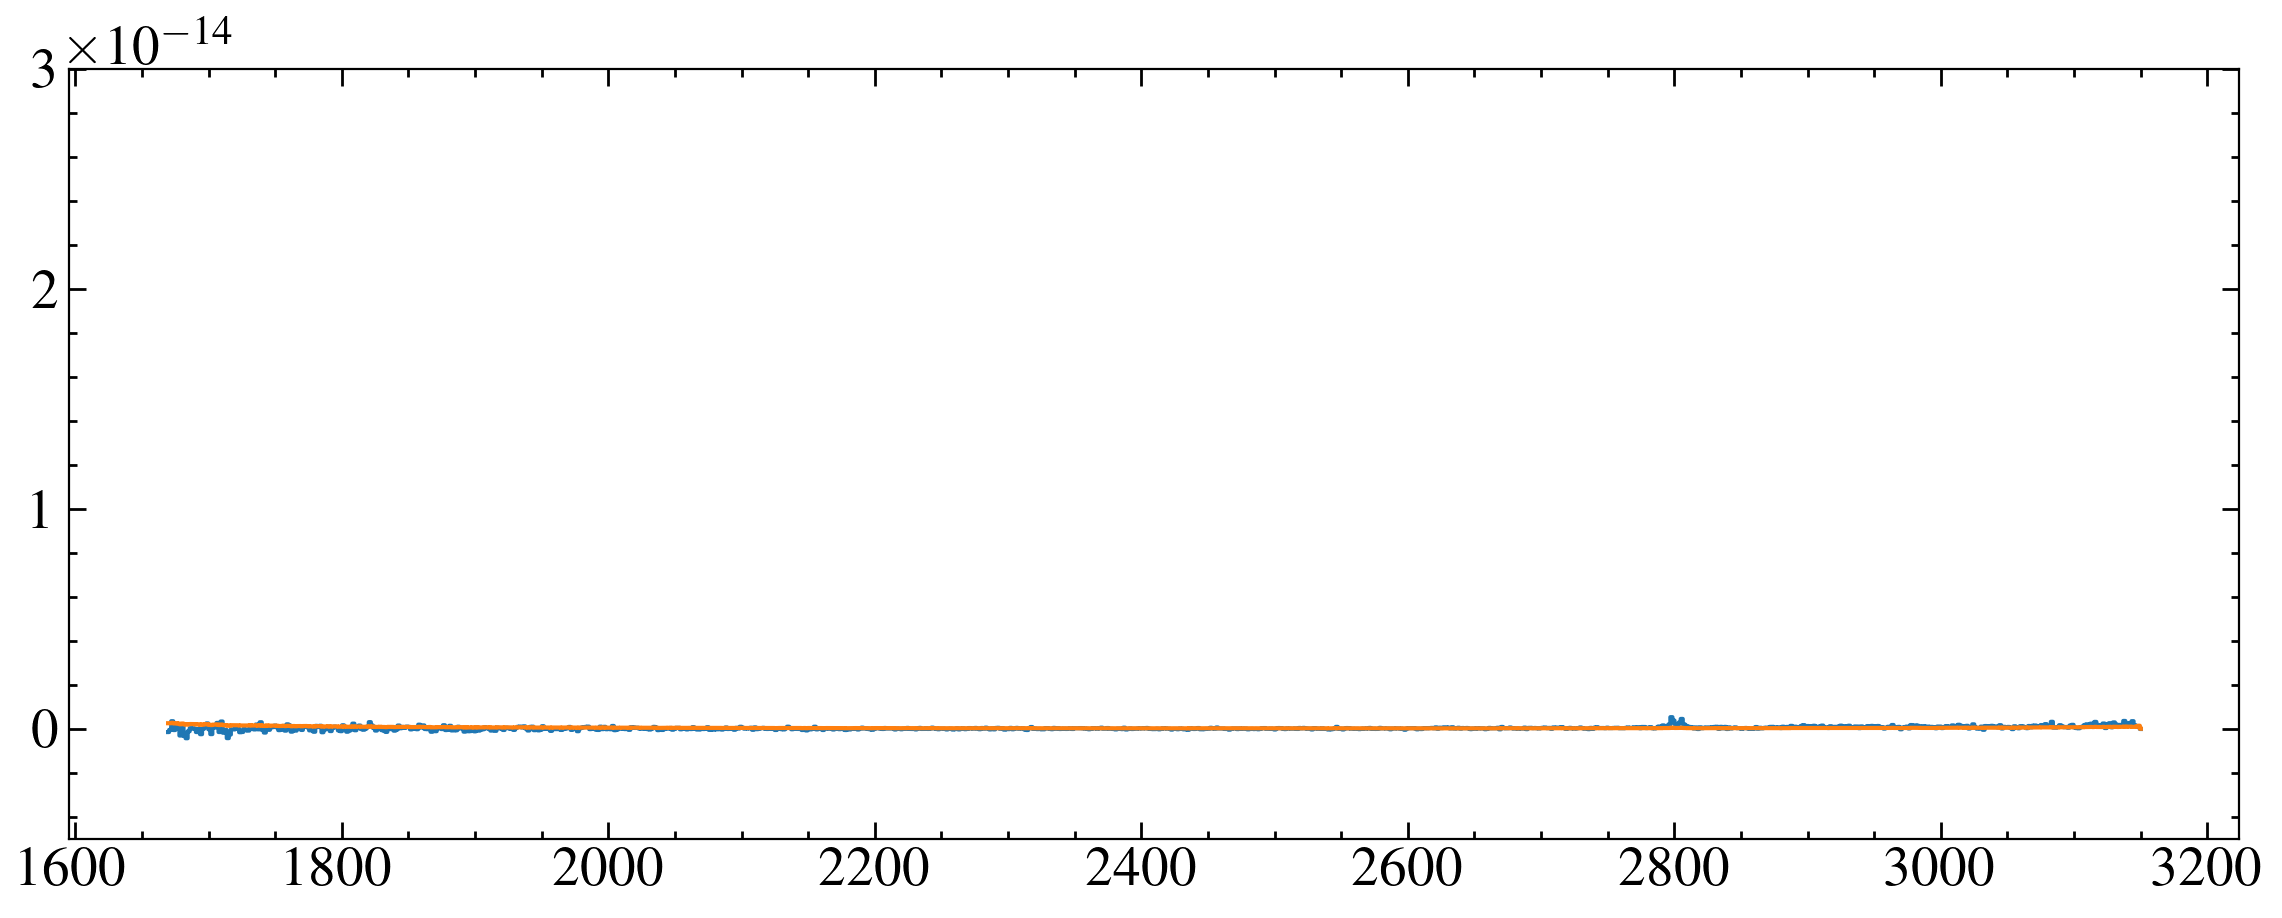

reextractions/gj4102/oeoo09030_new_x1d.fits
G140L
138.77849


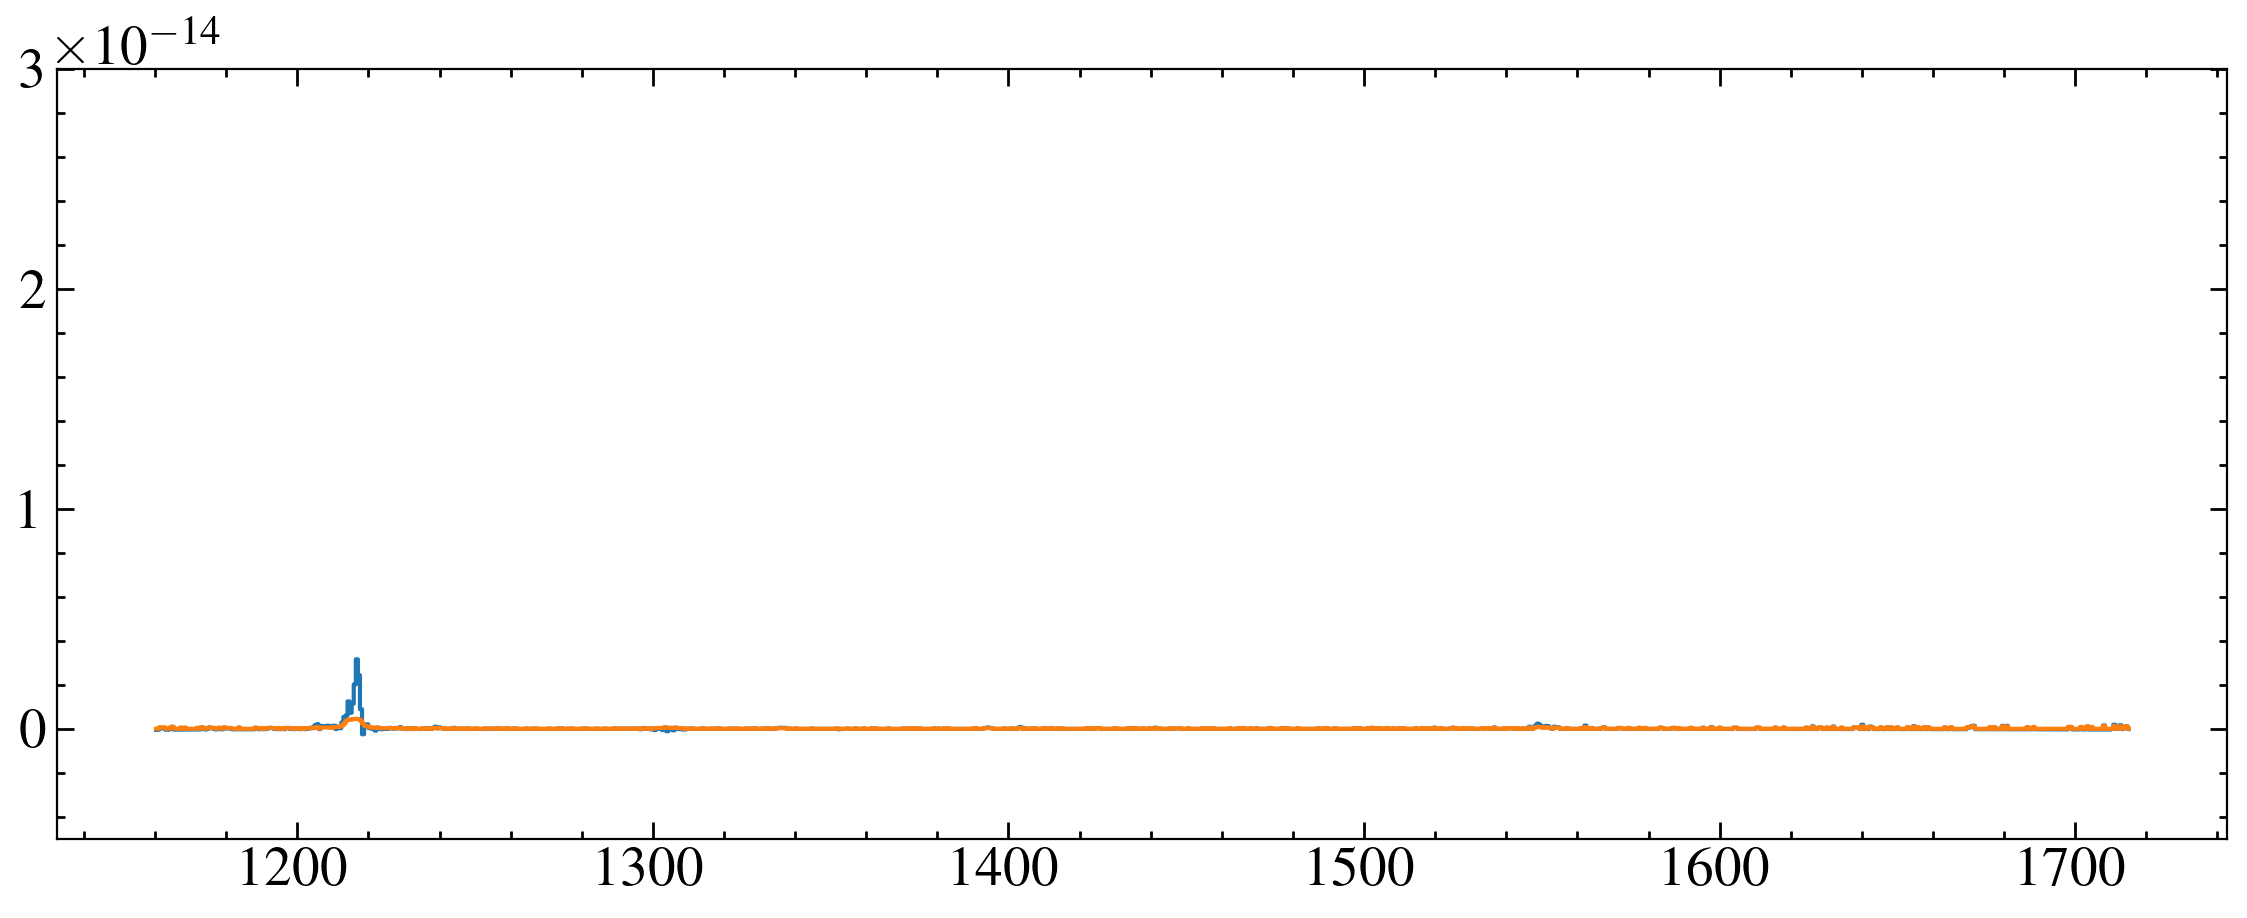

reextractions/gj4102/oeoo09040_new_x1d.fits
G140L
137.19199


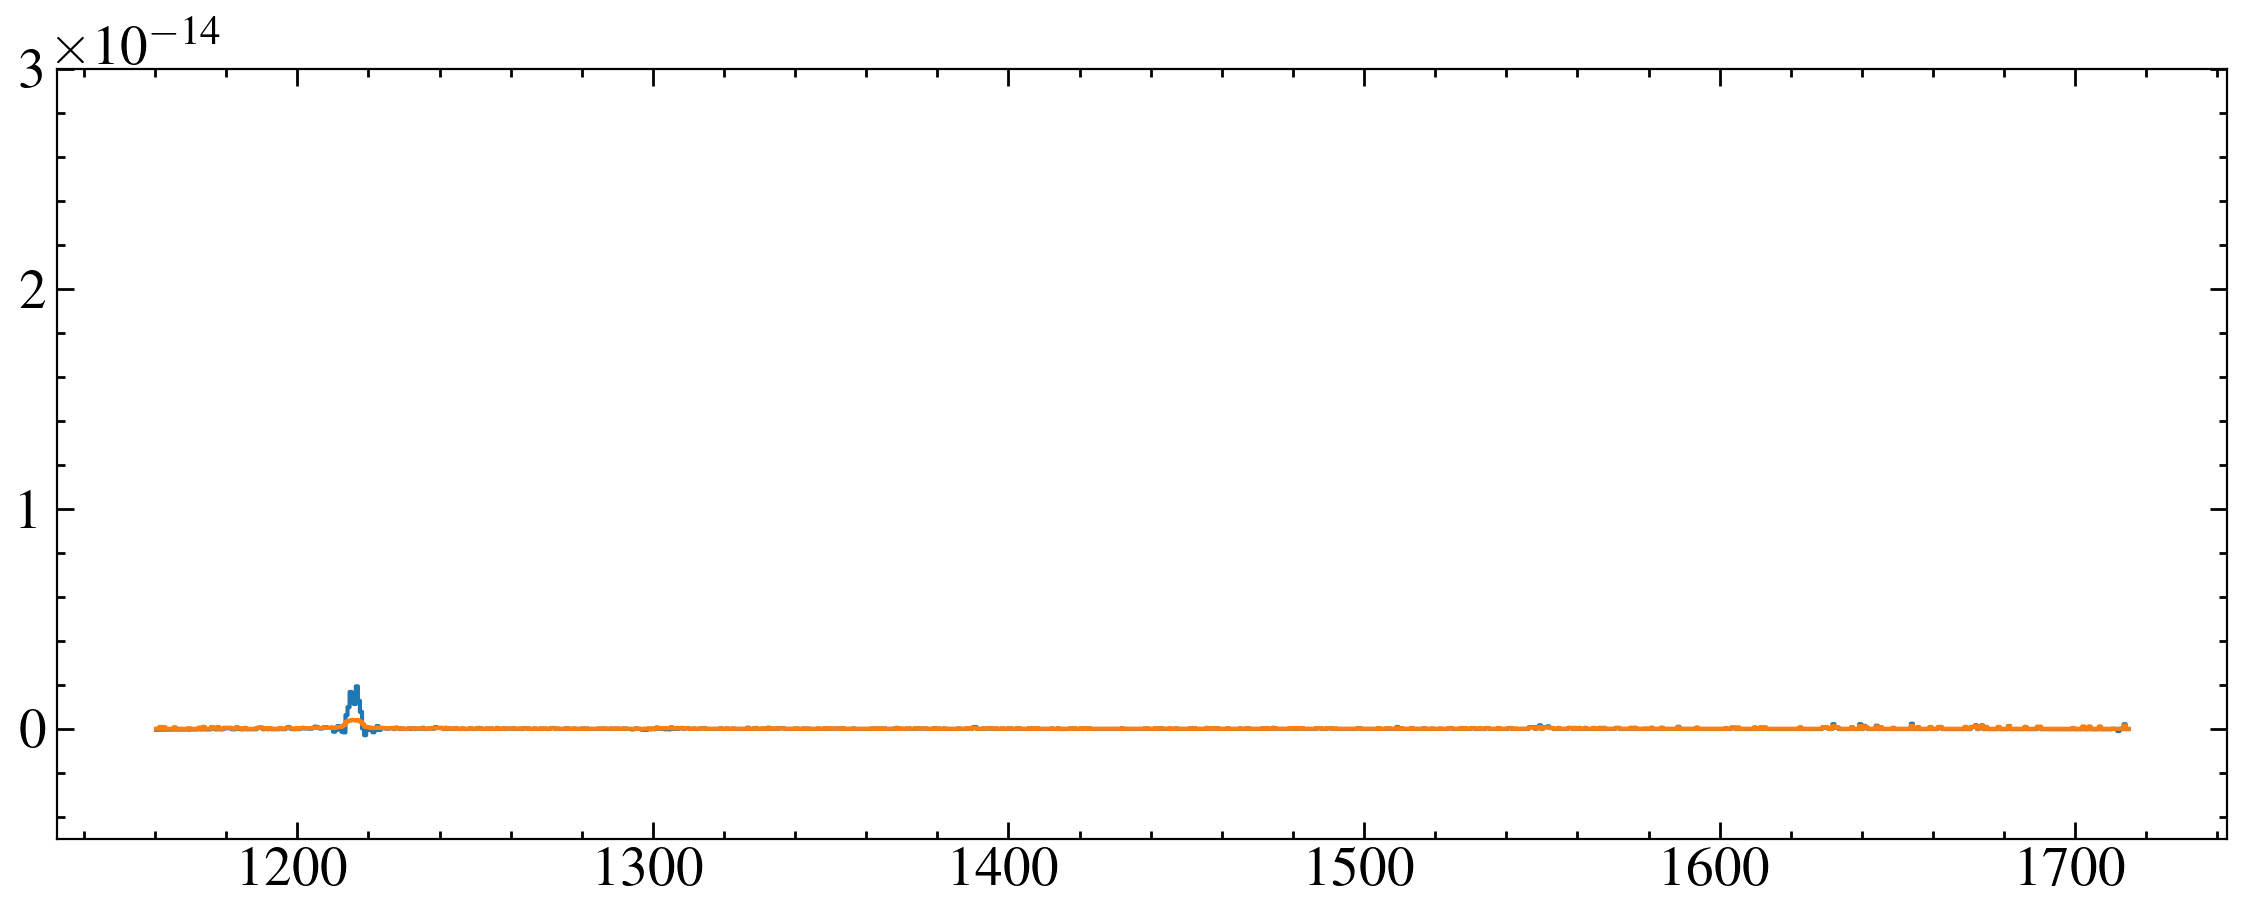

reextractions/gj4102/oeoo08020_new_x1d.fits
G140M
159.89096


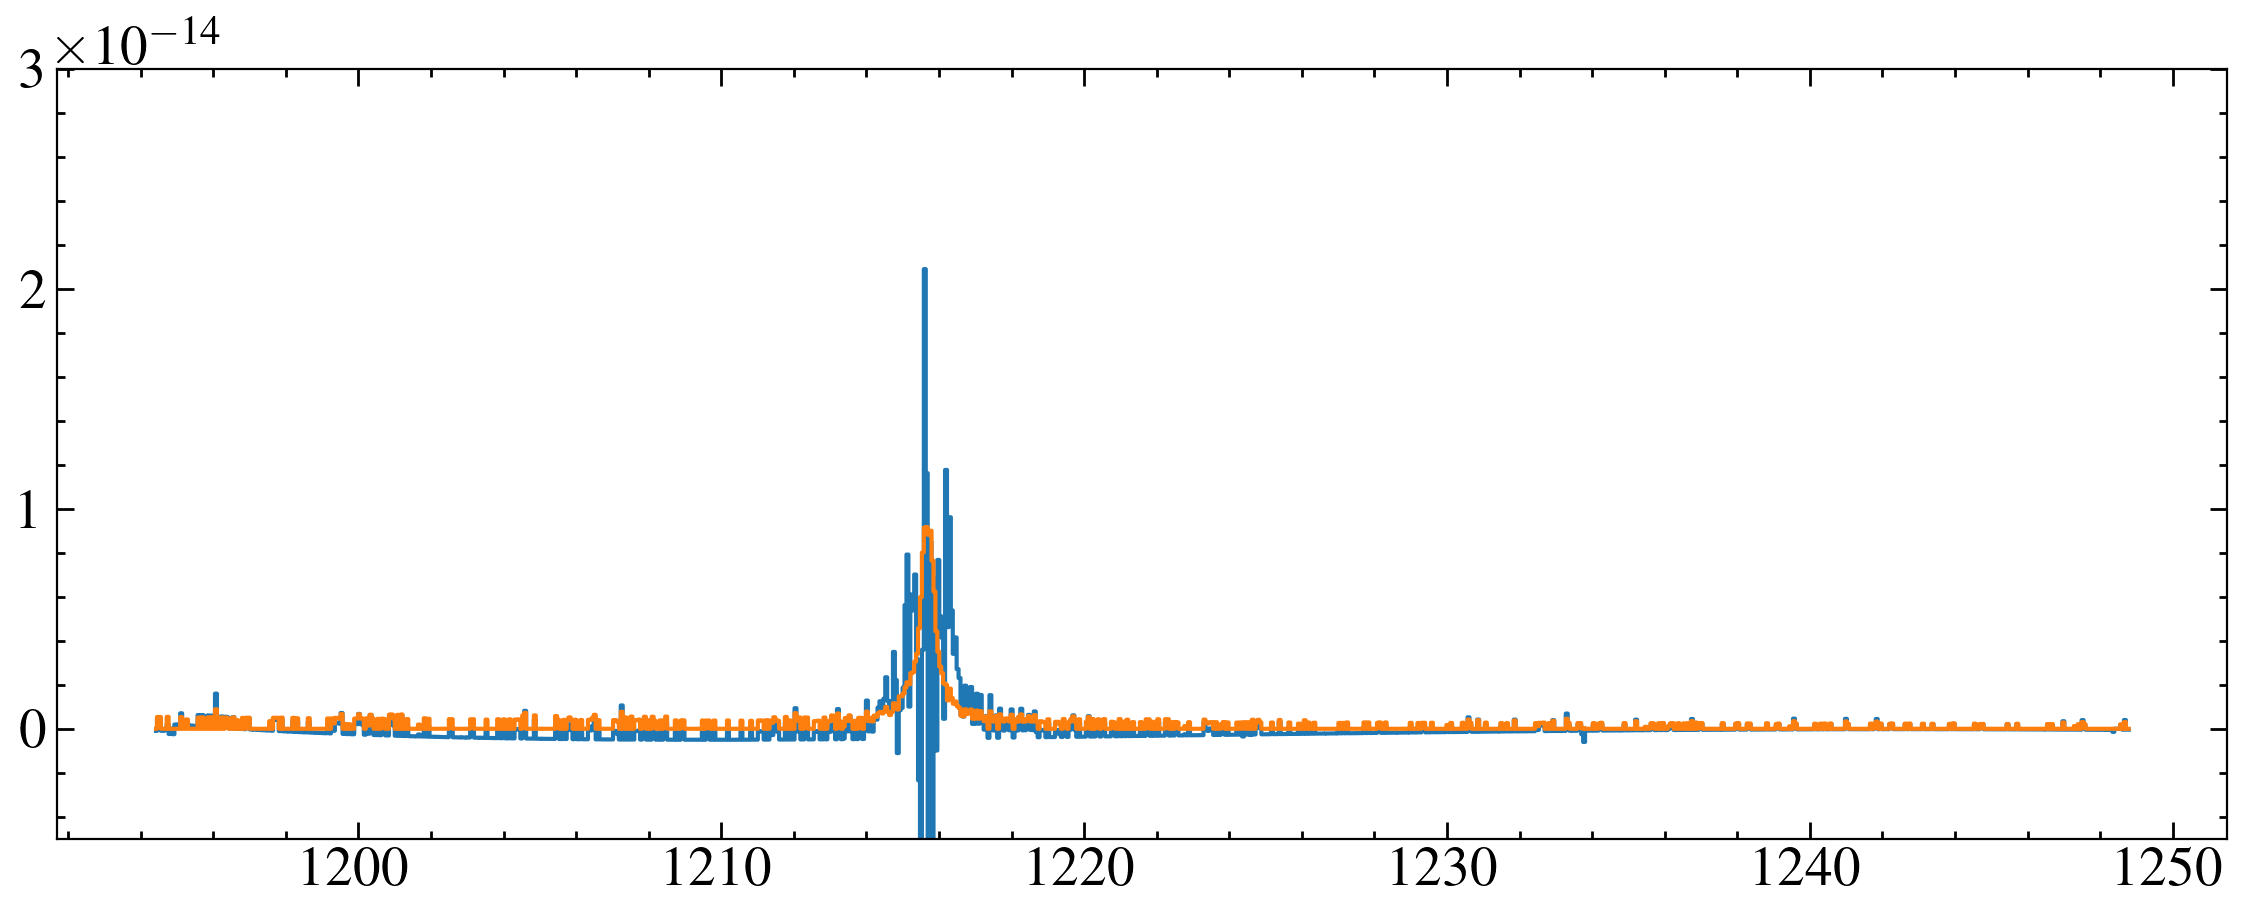

reextractions/gj4102/oeoo08030_new_x1d.fits
G140M
159.94882


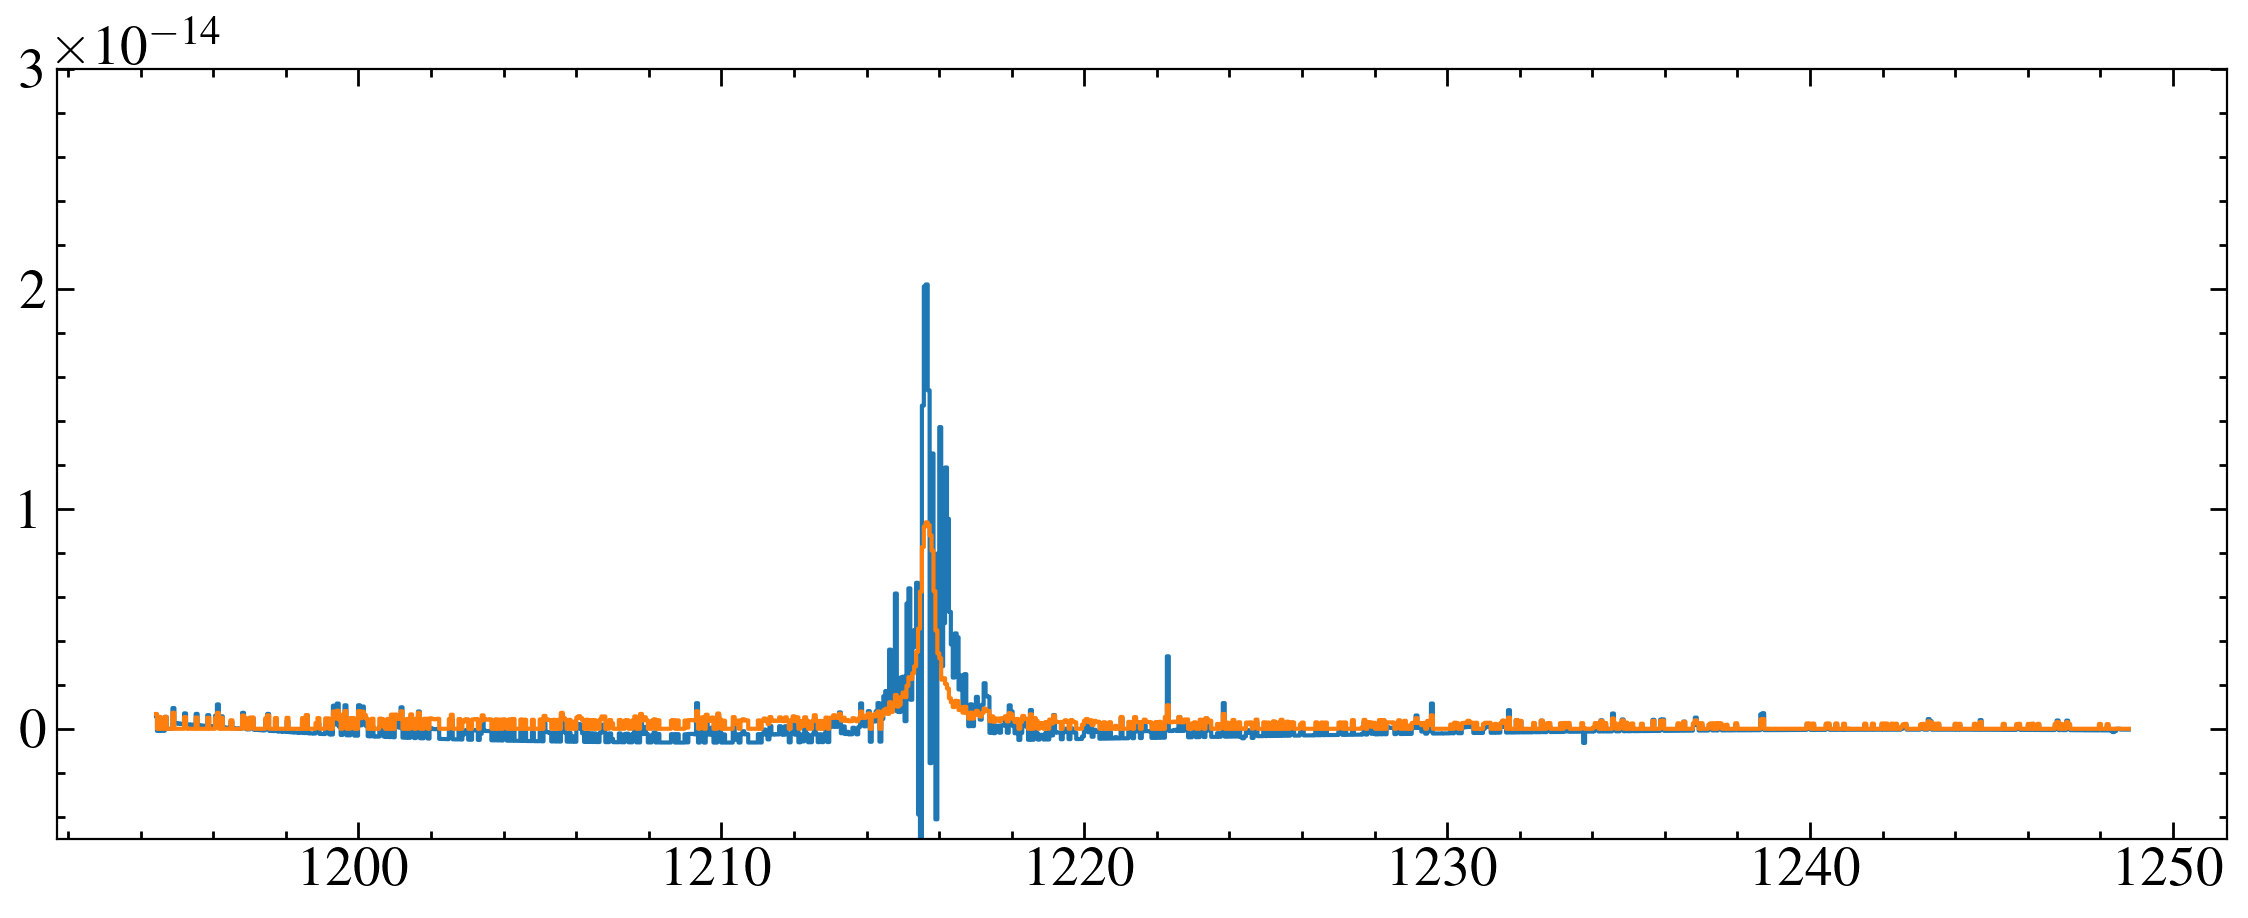

reextractions/gj4102/oeoo08010_new_x1d.fits
G140M
156.99675


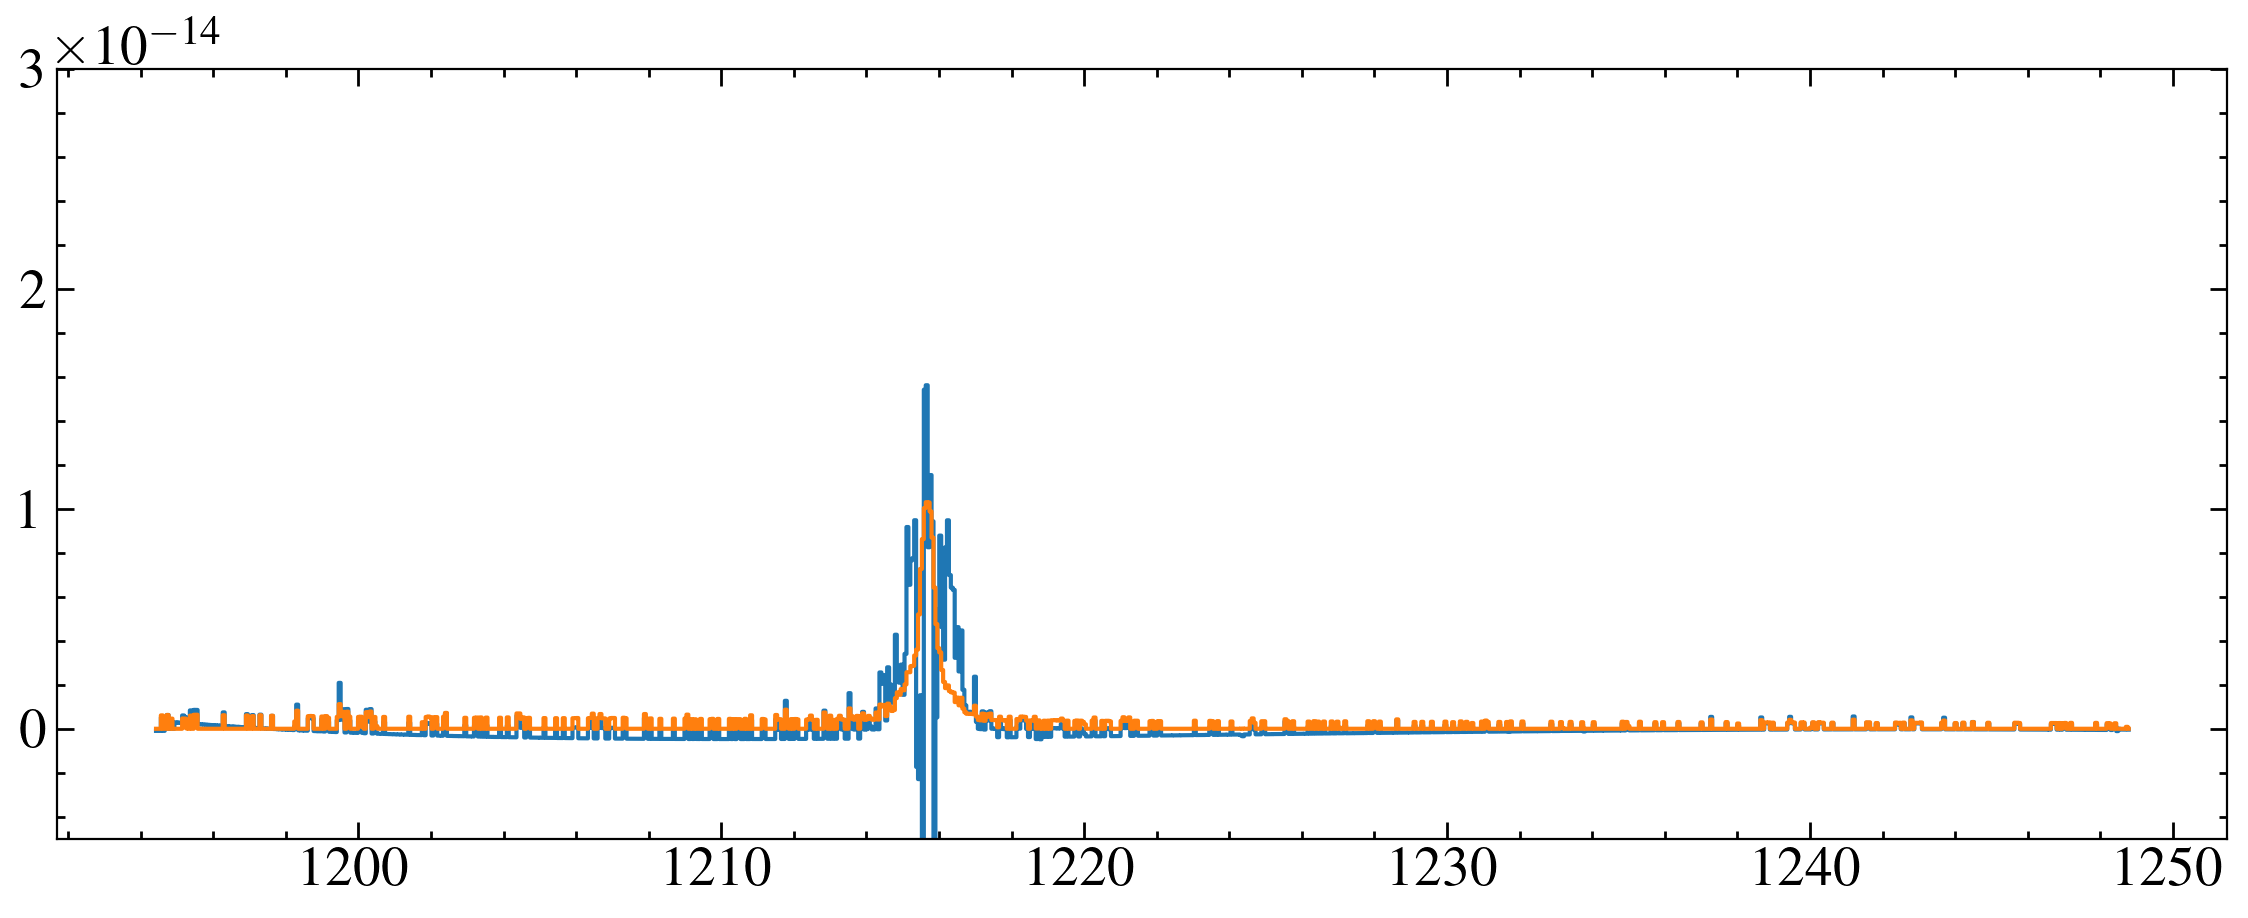

In [7]:
xs = [405, 408, 410]
ys = [157, 157, 158]

for i, root in  enumerate(roots):
    flt = '{}/{}_flt.fits'.format(path, root)
    SPTRCTAB = fits.getheader(flt,0)['SPTRCTAB']
    grating = fits.getheader(flt,0)['OPT_ELEM']
    cenwave = fits.getheader(flt,0)['CENWAVE']
    tracegrid = build_trace_grid(path+SPTRCTAB[5:], grating, cenwave)
    rootname = fits.getheader(flt)['ROOTNAME'] 
    outname = 'reextractions/gj4102/{}_new_x1d.fits'.format(rootname)
    if os.path.exists(outname):
        os.remove(outname)
    a2center = get_a2center(xs[i],ys[i], tracegrid)
    print(root)
    print(a2center)
    # a2center = 375
    stistools.x1d.x1d(flt, output = outname, trailer='reextractions/gj4102/{}_new.trl'.format(rootname), a2center=a2center,
                      maxsrch=5, bk1offst=-30, bk2offst=30,
                      bk1size=5, bk2size=5)
    # print(fits.getdata('reextractions/gj4102/{}_new_x1d.fits'.format(rootname),1)['A2CENTER'])
    
new_x1ds = glob.glob('reextractions/gj4102/*new_x1d.fits')
for x in new_x1ds:
    print(x)
    grating = fits.getheader(x, 0)['OPT_ELEM'] 
    print(grating)
    data = fits.getdata(x, 1)[0]
    print(data['A2Center'])
    w, f, e, dq= data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['DQ']
    if grating in ['G140M', 'G140L']:
        mask = (w > 1160) #& (w < 1210) | (w > 1220)

    
    w, f, e = w[mask], f[mask], e[mask]

    plt.step(w, f, where='mid')
    plt.step(w, e, where='mid')
    plt.ylim(-0.5e-14,3e-14 )
    plt.show()
    


In [8]:
new_x1ds = glob.glob('reextractions/gj4102/*new_x1d.fits')
new_x1ds

['reextractions/gj4102/oeoo09010_new_x1d.fits',
 'reextractions/gj4102/oeoo09020_new_x1d.fits',
 'reextractions/gj4102/oeoo09030_new_x1d.fits',
 'reextractions/gj4102/oeoo09040_new_x1d.fits',
 'reextractions/gj4102/oeoo08020_new_x1d.fits',
 'reextractions/gj4102/oeoo08030_new_x1d.fits',
 'reextractions/gj4102/oeoo08010_new_x1d.fits']

In [9]:
def spectra_adder(f_array, e_array, scale_correct=True):
    """
    Returns a variance-weighted coadd with standard error of the weighted mean (variance weights, scale corrected).
    f_array and e_arrays are collections of flux and error arrays, which should have the same lenth and wavelength scale
    """
    weights = 1 / (e_array**2)
    flux = np.average(f_array, axis =0, weights = weights)
    var = 1 / np.sum(weights, axis=0)
    rcs = np.sum((((flux - f_array)**2) * weights), axis=0) / (len(f_array)-1) #reduced chi-squared
    if scale_correct:
        error = (var * rcs)**0.5
    else:
        error = var**0.5
    return flux,error

In [10]:
x1ds = np.hstack((new_x1ds, st_x1ds))
x1ds

array(['reextractions/gj4102/oeoo09010_new_x1d.fits',
       'reextractions/gj4102/oeoo09020_new_x1d.fits',
       'reextractions/gj4102/oeoo09030_new_x1d.fits',
       'reextractions/gj4102/oeoo09040_new_x1d.fits',
       'reextractions/gj4102/oeoo08020_new_x1d.fits',
       'reextractions/gj4102/oeoo08030_new_x1d.fits',
       'reextractions/gj4102/oeoo08010_new_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/gj4102/16701_07/data/oeoo07010_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/gj4102/16701_07/data/oeoo07020_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/gj4102/16701_07/data/oeoo07030_x1d.fits'],
      dtype='<U80')

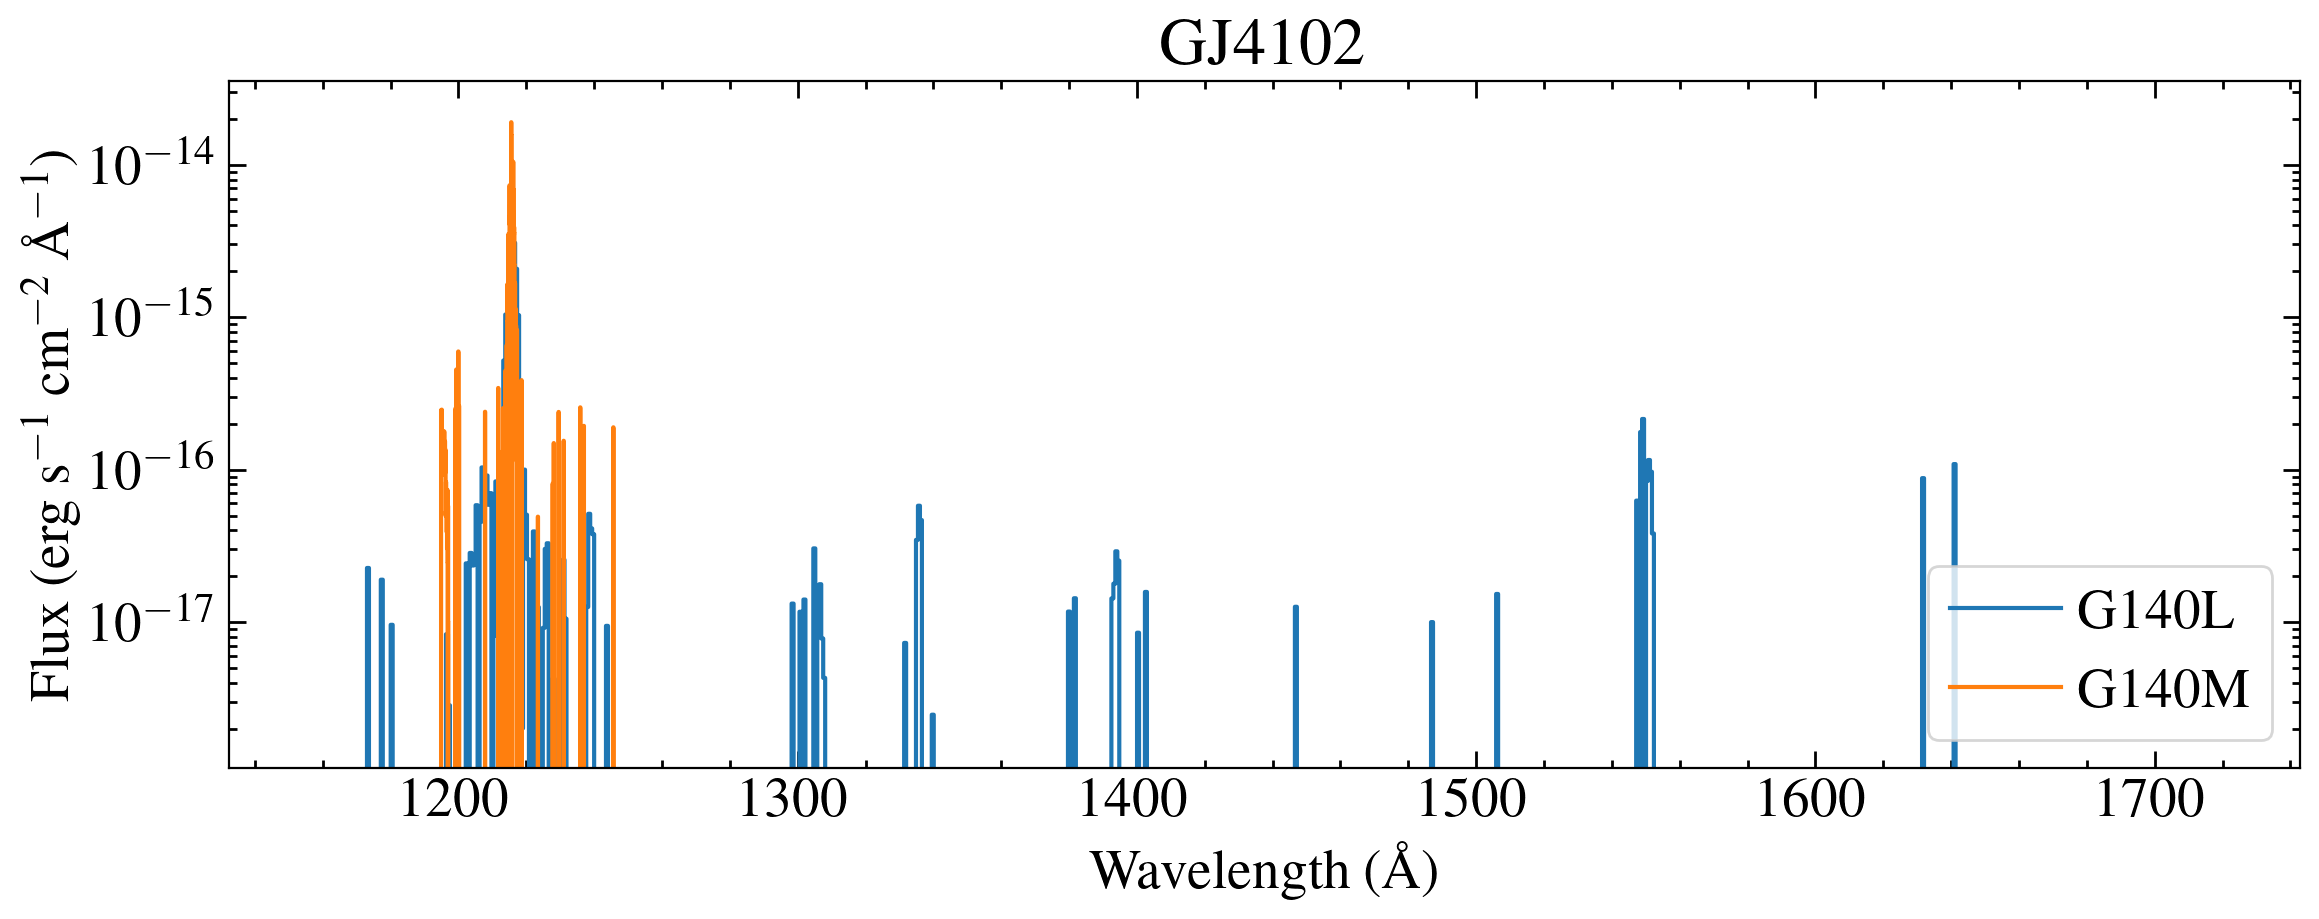

In [11]:


plt.figure(figsize=(12, 5))

f_nuv = []
e_nuv = []
f_fuv = []
e_fuv = []
f_lya = []
e_lya = []

n=0
o=0
p=0
for x in x1ds:
    data = fits.getdata(x, 1)[0]
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    grating = fits.getheader(x, 0)['OPT_ELEM']
    if grating == 'G230L':
        mask = (w > 1800) & (w <3130)
        w, f, e = w[mask], f[mask], e[mask]
        if n == 0:
            w_nuv = w
            f_nuv.append(f)
            e_nuv.append(e)
        else:
            f_nuv.append(interp1d(w, f, fill_value='extrapolate')(w_nuv))
            e_nuv.append(interp1d(w, e, fill_value='extrapolate')(w_nuv))            
        n +=1
    if grating == 'G140L':
        mask = (w > 1160)# & (w <1700)
        w, f, e = w[mask], f[mask], e[mask]
        if o == 0:
            w_fuv = w
            f_fuv.append(f)
            e_fuv.append(e)
        else:
            f_fuv.append(interp1d(w, f, fill_value='extrapolate')(w_fuv))
            e_fuv.append(interp1d(w, e, fill_value='extrapolate')(w_fuv))            
        o +=1
    if grating == 'G140M':
        # mask = (w > 1160) & (w <1700)
        # w, f, e = w[mask], f[mask], e[mask]
        if p == 0:
            w_lya = w
            f_lya.append(f)
            e_lya.append(e)
        else:
            f_lya.append(interp1d(w, f, fill_value='extrapolate')(w_lya))
            e_lya.append(interp1d(w, e, fill_value='extrapolate')(w_lya))            
        p +=1
    if grating == 'G430L':
        mask = (w > 3050) & (w <5520)
        w_opt, f_opt, e_opt = w[mask], f[mask], e[mask]
        
# f_nuv, e_nuv = spectra_adder(np.array(f_nuv), np.array(e_nuv), scale_correct=True)
f_fuv, e_fuv = spectra_adder(np.array(f_fuv), np.array(e_fuv), scale_correct=True)
f_lya, e_lya = spectra_adder(np.array(f_lya), np.array(e_lya), scale_correct=True)

plt.step(w_fuv, f_fuv, label='G140L')
# plt.step(w_nuv, f_nuv, label='G230L')
plt.step(w_lya, f_lya, label='G140M')
# plt.step(w_opt, f_opt, label='G430L', zorder=-1)

plt.yscale('log')
# plt.xscale('log')
plt.ylim(1.1e-18)
# plt.xlim(1060, 5520)
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.legend(frameon=True, loc=4)
plt.title('GJ4102')
plt.tight_layout()

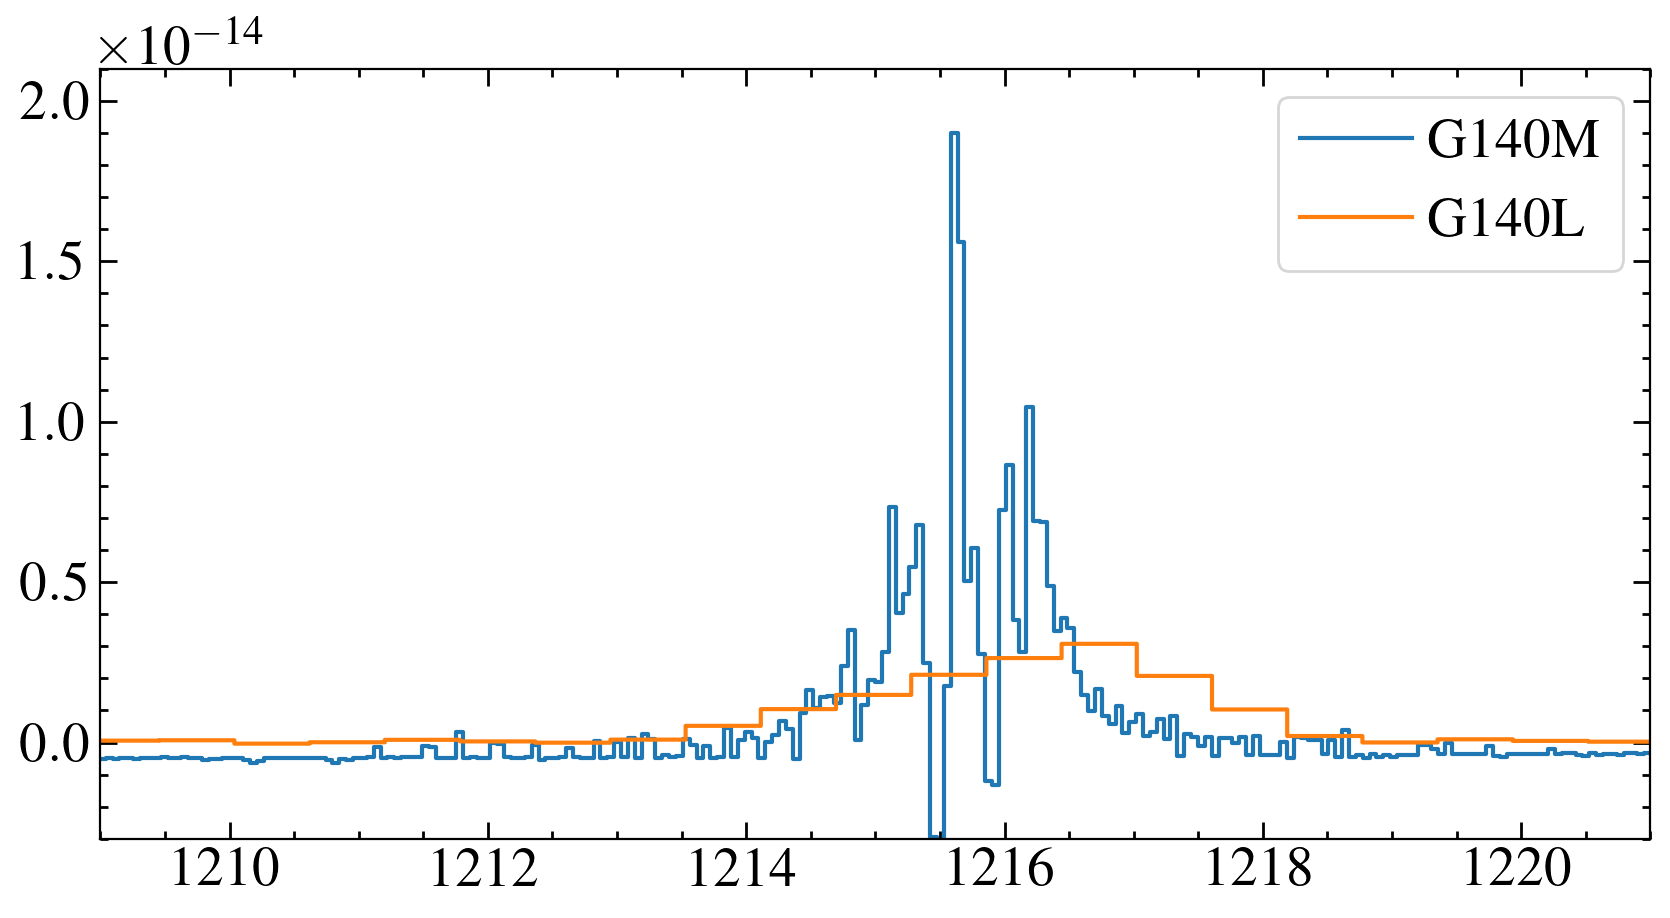

In [12]:
fig, ax=plt.subplots(figsize=(10,5))

plt.step(w_lya, f_lya, label='G140M',where='mid')

plt.step(w_fuv, f_fuv, label='G140L', where='mid')

plt.xlim(1209, 1221)
plt.ylim(-0.3e-14, 2.1e-14)
ax.legend(frameon=True)

Got new G140M, G230L and G430L data. F/NUV data need rextracting.  oeoo09050= G430L, looks fine

In [13]:
npath = '/media/david/2tb_ext_hd/hddata/meats/hst/gj4102/may_obs/'
flts = glob.glob('{}*flt.fits'.format(npath))
# flts
g430l=  glob.glob('{}*sx1.fits'.format(npath))
g430l

['/media/david/2tb_ext_hd/hddata/meats/hst/gj4102/may_obs/oeoo09050_sx1.fits']

In [14]:
os.environ['oref'] = npath

oeoo09010
G230L
532.8642


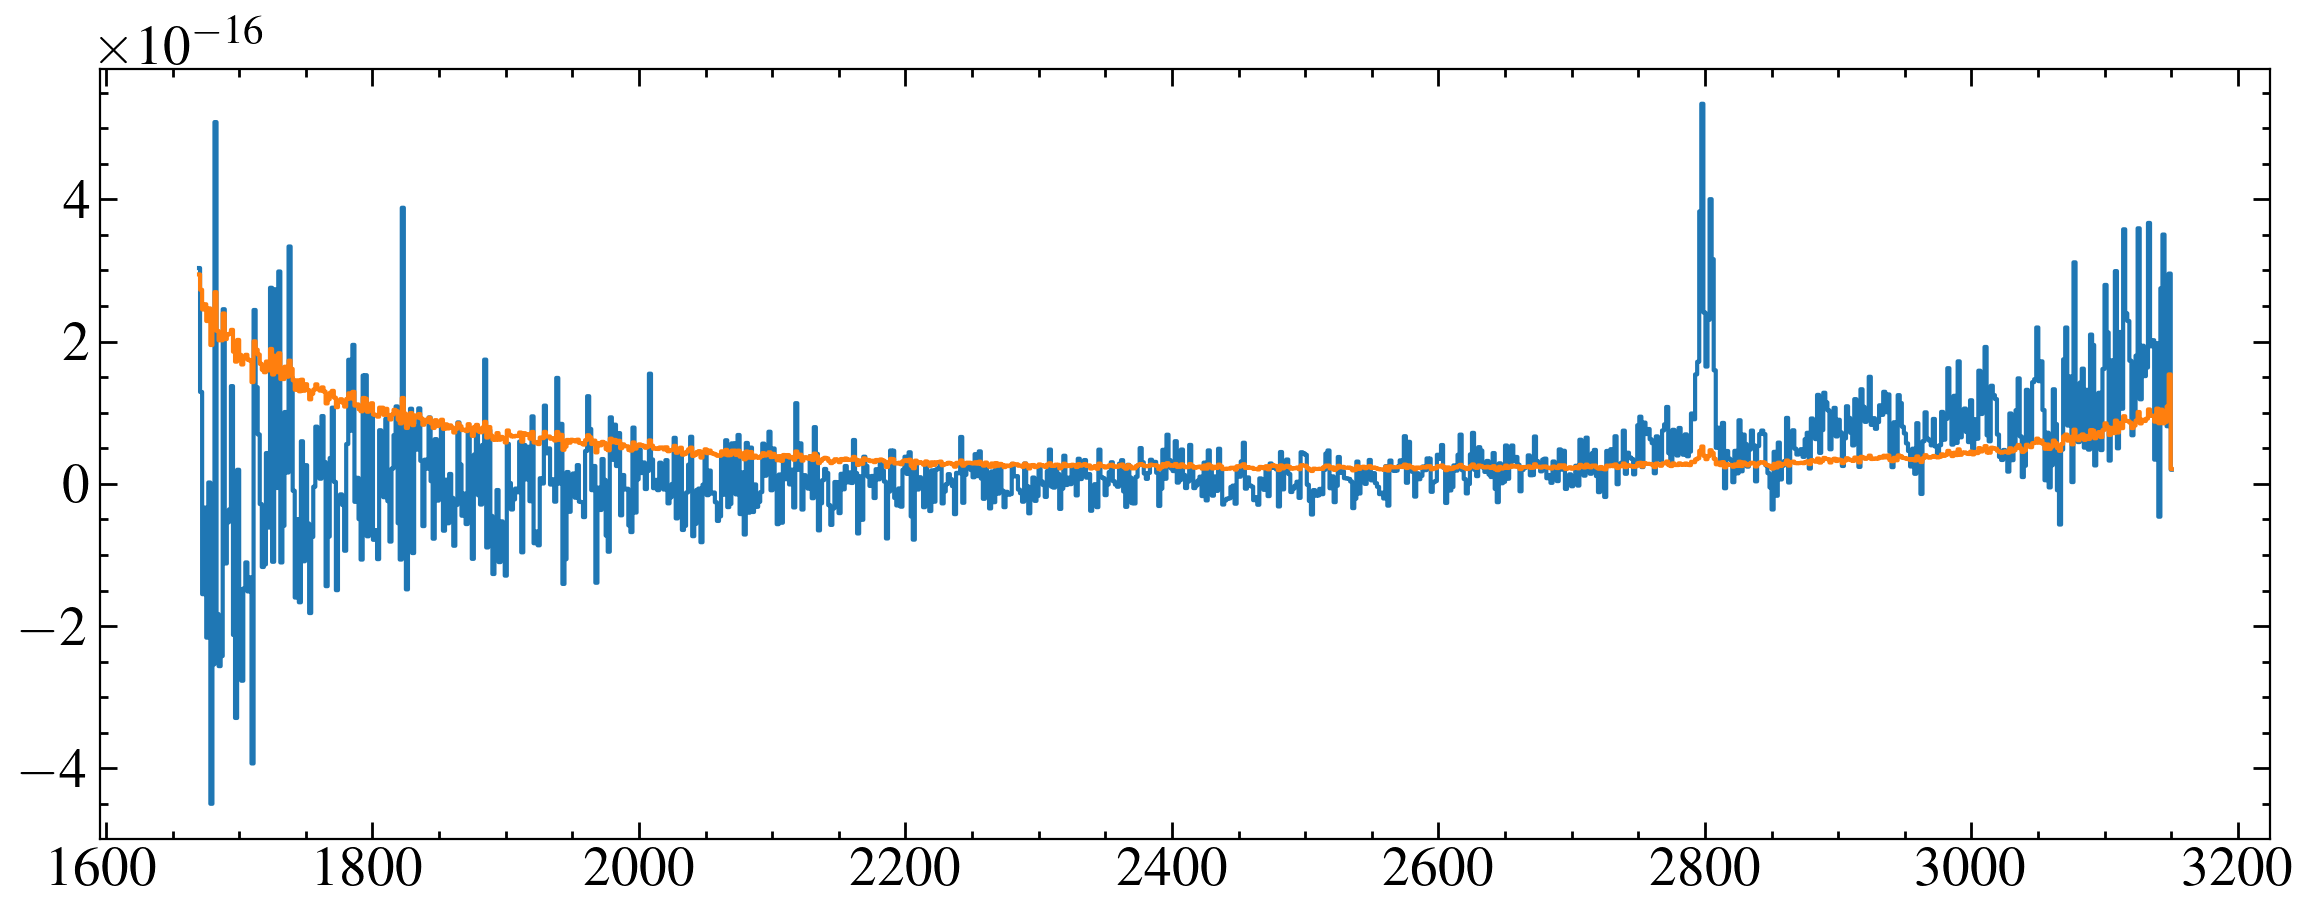

oeoo09020
G230L
533.0787


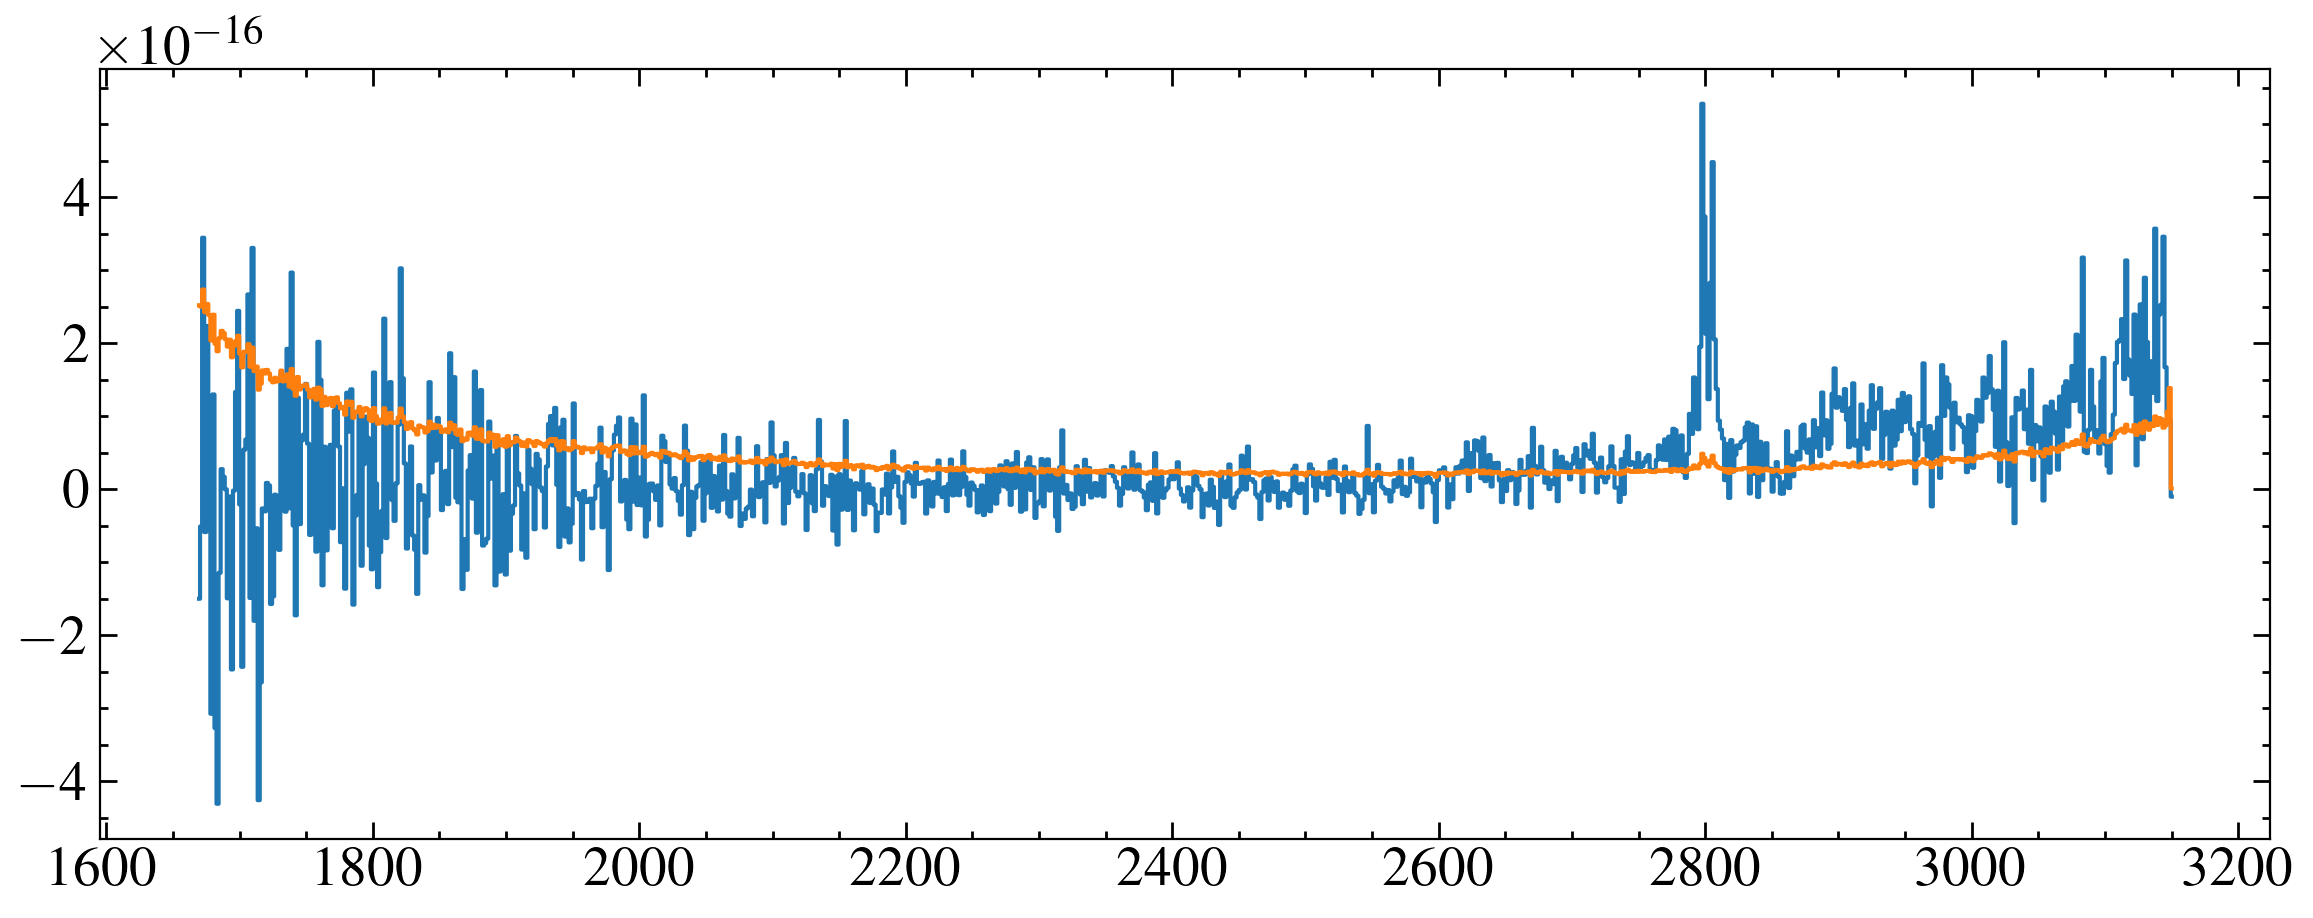

oeoo09030
G140L
138.77849


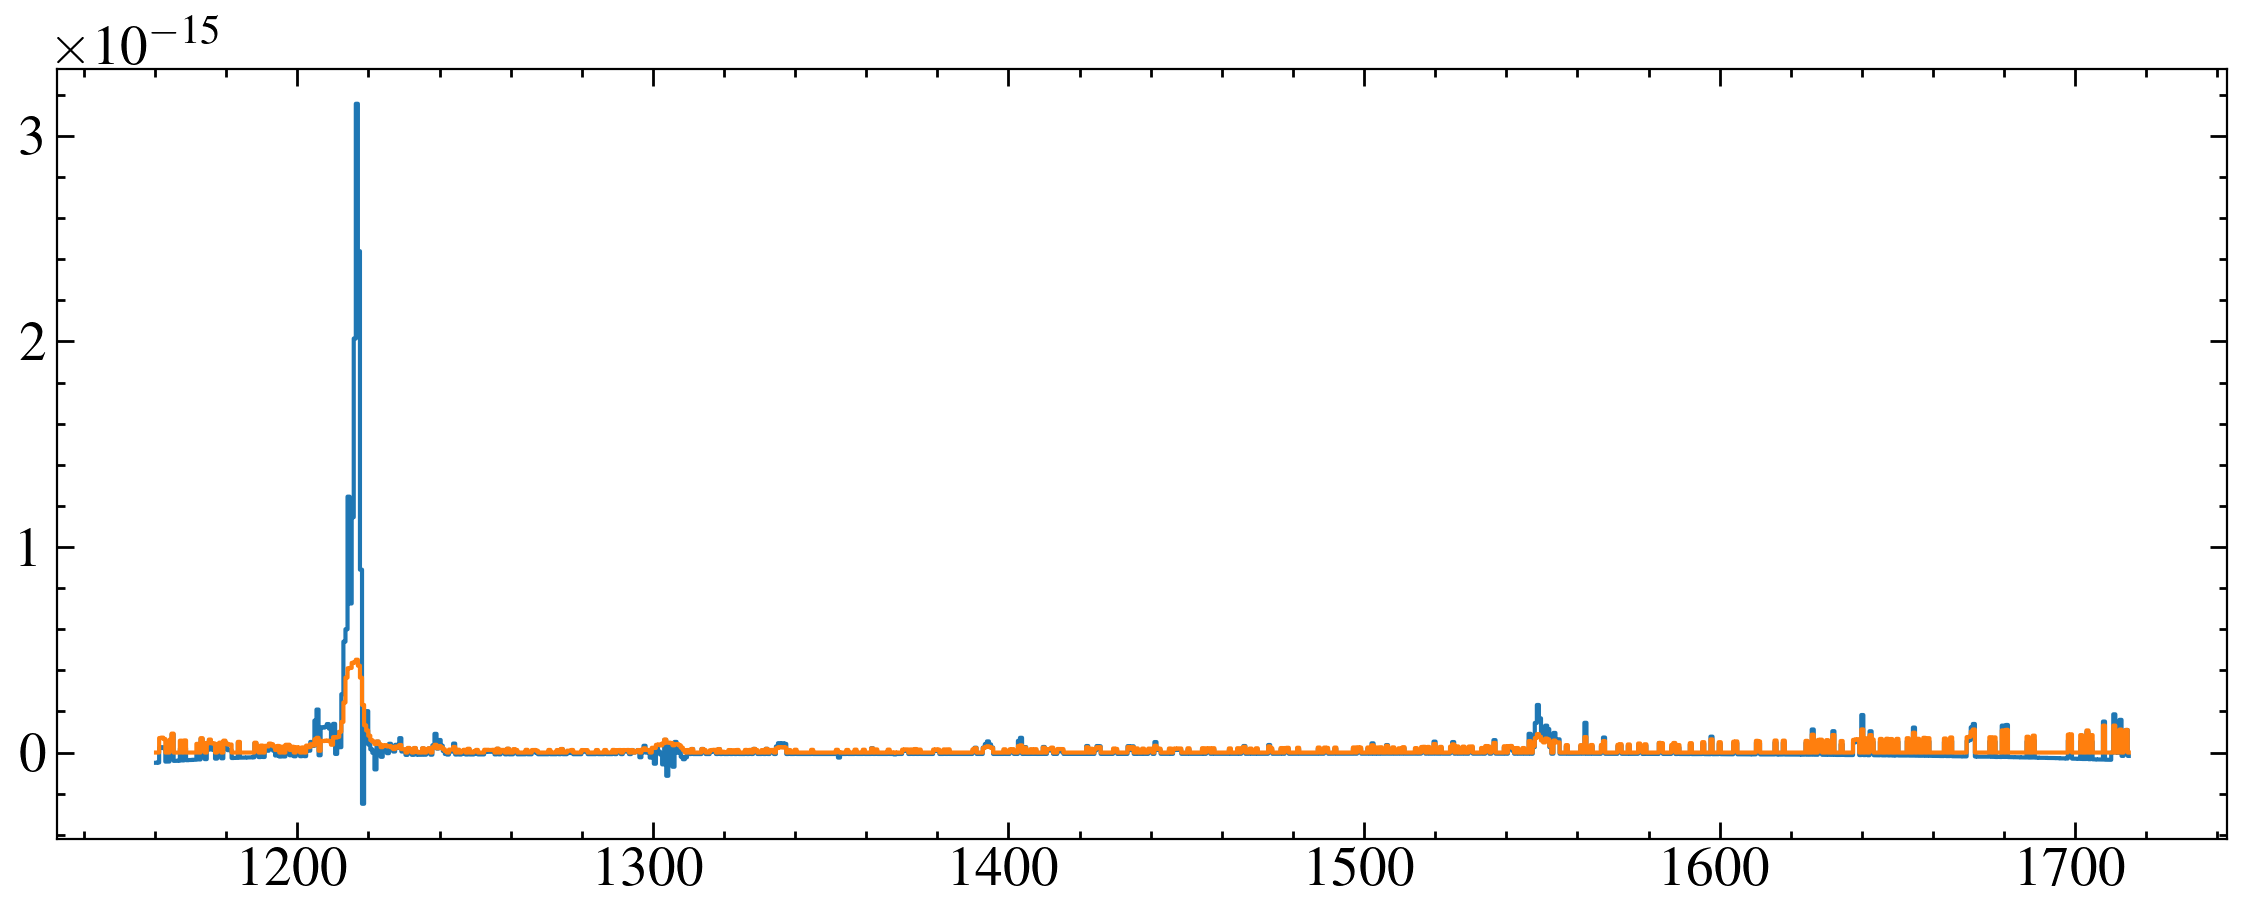

oeoo09040
G140L
137.19199


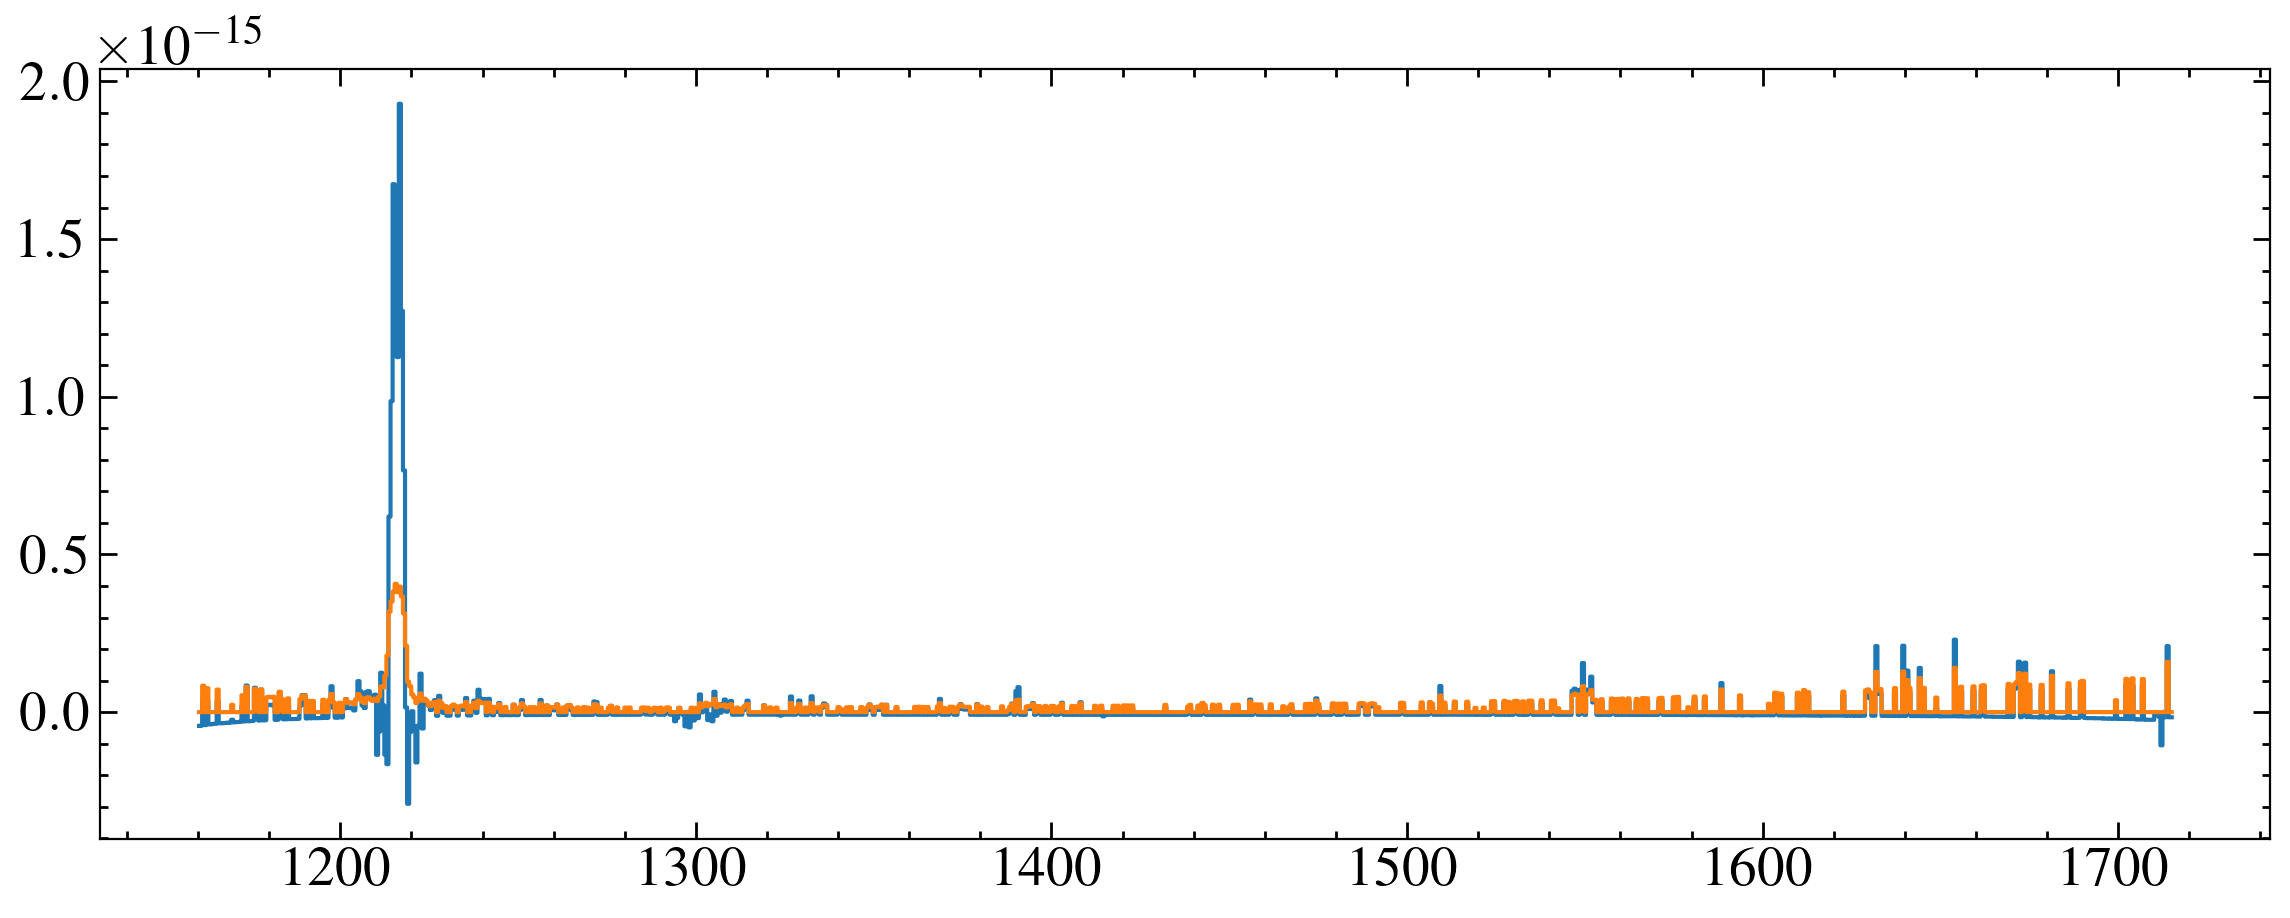

In [15]:
roots = ['oeoo09010', 'oeoo09020','oeoo09030','oeoo09040']

# xs = [405, 408, 410]
ys = [526, 526, 136,136]



for i, root in  enumerate(roots):
    flt = '{}/{}_flt.fits'.format(npath, root)
    SPTRCTAB = fits.getheader(flt,0)['SPTRCTAB']
    grating = fits.getheader(flt,0)['OPT_ELEM']
    cenwave = fits.getheader(flt,0)['CENWAVE']
    # tracegrid = build_trace_grid(path+SPTRCTAB[5:], grating, cenwave)
    rootname = fits.getheader(flt)['ROOTNAME'] 
    outname = 'reextractions/gj4102/{}_new_x1d.fits'.format(rootname)
    if os.path.exists(outname):
        os.remove(outname)
    # a2center = get_a2center(xs[i],ys[i], tracegrid)
    # print(root)
    # print(a2center)
    a2center = ys[i]
    stistools.x1d.x1d(flt, output = outname, trailer='reextractions/gj4102/{}_new.trl'.format(rootname), a2center=a2center,
                      maxsrch=10, bk1offst=-30, bk2offst=30,
                      bk1size=5, bk2size=5)
    # print(fits.getdata('reextractions/gj4102/{}_new_x1d.fits'.format(rootname),1)['A2CENTER'])
    
new_x1ds = glob.glob('reextractions/gj4102/*new_x1d.fits')
for x in new_x1ds:
    # print(x)
    root = fits.getheader(x, 0)['ROOTNAME']
    if root in roots:

        print(root)
        grating = fits.getheader(x, 0)['OPT_ELEM'] 
        print(grating)
        data = fits.getdata(x, 1)[0]
        print(data['A2Center'])
        w, f, e, dq= data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['DQ']
        if grating in ['G140M', 'G140L']:
            mask = (w > 1160) #& (w < 1210) | (w > 1220)


        w, f, e = w[mask], f[mask], e[mask]

        plt.step(w, f, where='mid')
        plt.step(w, e, where='mid')
        # plt.ylim(-0.5e-14,3e-14 )
        plt.show()



In [16]:
x1ds = np.hstack((new_x1ds, st_x1ds, g430l))
x1ds

array(['reextractions/gj4102/oeoo09010_new_x1d.fits',
       'reextractions/gj4102/oeoo09020_new_x1d.fits',
       'reextractions/gj4102/oeoo09030_new_x1d.fits',
       'reextractions/gj4102/oeoo09040_new_x1d.fits',
       'reextractions/gj4102/oeoo08020_new_x1d.fits',
       'reextractions/gj4102/oeoo08030_new_x1d.fits',
       'reextractions/gj4102/oeoo08010_new_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/gj4102/16701_07/data/oeoo07010_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/gj4102/16701_07/data/oeoo07020_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/gj4102/16701_07/data/oeoo07030_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/gj4102/may_obs/oeoo09050_sx1.fits'],
      dtype='<U80')

Need to do the fancy person errors thing for the fuv

In [17]:
import astropy.stats as stats
def make_person_errors(data, hdr):
    """
    Recalculates the error array using a pearson confidence interval - this corrects for the pipeline producing errors with zero
    """
    sensitivity = data['FLUX'] / data['NET'] #sensitivity curve of the spectrum 
    counts = data['GROSS'] * hdr['EXPTIME'] #total counts obtained in each wavelength bin during the exposure
    ci = stats.poisson_conf_interval(counts, interval='pearson') #pearson confidence interval
    ci = np.nan_to_num(ci, nan=0.0)
    count_errors = np.mean(abs(ci -counts), axis = 0) #average the upper and lower errorbars
    new_error = count_errors * sensitivity/hdr['EXPTIME'] #convert error to flux units    
    return new_error


/home/david/anaconda3/envs/stenv/lib/python3.11/site-packages/astropy/stats/funcs.py:698: RuntimeWarning: invalid value encountered in sqrt
  [n + 0.5 - np.sqrt(n + 0.25), n + 0.5 + np.sqrt(n + 0.25)]


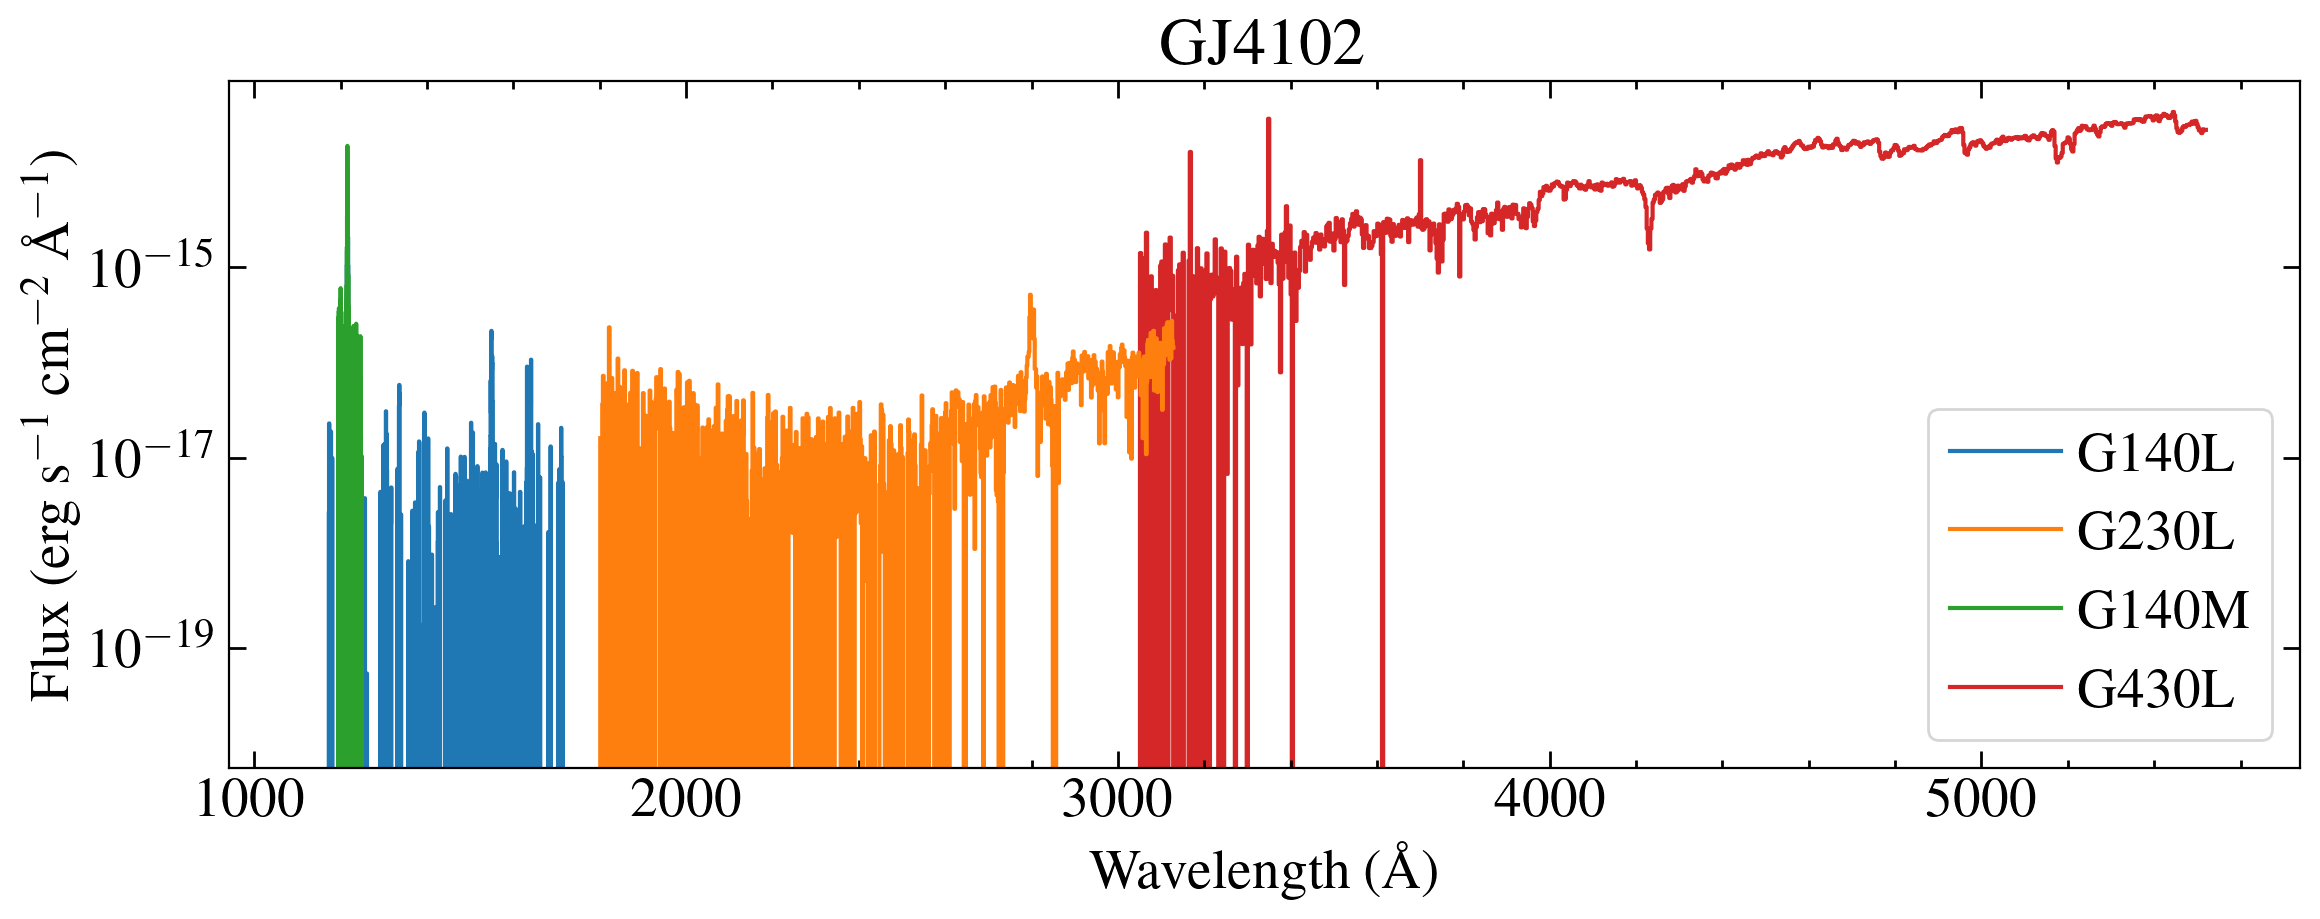

In [18]:


plt.figure(figsize=(12, 5))

f_nuv = []
e_nuv = []
f_fuv = []
e_fuv = []
f_lya = []
e_lya = []

n=0
o=0
p=0
for x in x1ds:
    data = fits.getdata(x, 1)[0]
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    hdr = fits.getheader(x, 0)
    hdr1 = fits.getheader(x, 1)
    grating = hdr['OPT_ELEM']
    if grating == 'G230L':
        mask = (w > 1800) & (w <3130)
        w, f, e = w[mask], f[mask], e[mask]
        if n == 0:
            w_nuv = w
            f_nuv.append(f)
            e_nuv.append(e)
        else:
            f_nuv.append(interp1d(w, f, fill_value='extrapolate')(w_nuv))
            e_nuv.append(interp1d(w, e, fill_value='extrapolate')(w_nuv))            
        n +=1
    if grating == 'G140L':
        mask = (w > 1160)# & (w <1700)
        e = make_person_errors(data, hdr1)
        w, f, e = w[mask], f[mask], e[mask]
        if o == 0:
            w_fuv = w
            f_fuv.append(f)
            e_fuv.append(e)
        else:
            f_fuv.append(interp1d(w, f, fill_value='extrapolate')(w_fuv))
            e_fuv.append(interp1d(w, e, fill_value='extrapolate')(w_fuv))            
        o +=1
    if grating == 'G140M':
        # mask = (w > 1160) & (w <1700)
        # w, f, e = w[mask], f[mask], e[mask]
        e = make_person_errors(data, hdr1)
        if p == 0:
            w_lya = w
            f_lya.append(f)
            e_lya.append(e)
        else:
            f_lya.append(interp1d(w, f, fill_value='extrapolate')(w_lya))
            e_lya.append(interp1d(w, e, fill_value='extrapolate')(w_lya))            
        p +=1
    if grating == 'G430L':
        mask = (w > 3050) & (w <5520)
        w_opt, f_opt, e_opt = w[mask], f[mask], e[mask]
        
f_nuv, e_nuv = spectra_adder(np.array(f_nuv), np.array(e_nuv), scale_correct=True)
f_fuv, e_fuv = spectra_adder(np.array(f_fuv), np.array(e_fuv), scale_correct=True)
f_lya, e_lya = spectra_adder(np.array(f_lya), np.array(e_lya), scale_correct=True)

plt.step(w_fuv, f_fuv, label='G140L')
plt.step(w_nuv, f_nuv, label='G230L')
plt.step(w_lya, f_lya, label='G140M')
plt.step(w_opt, f_opt, label='G430L', zorder=-1)

plt.yscale('log')
# plt.xscale('log')
# plt.ylim(1.1e-18)
# plt.xlim(1060, 5520)
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.legend(frameon=True, loc=4)
plt.title('GJ4102')
plt.tight_layout()

(-6e-17, 1.9e-16)

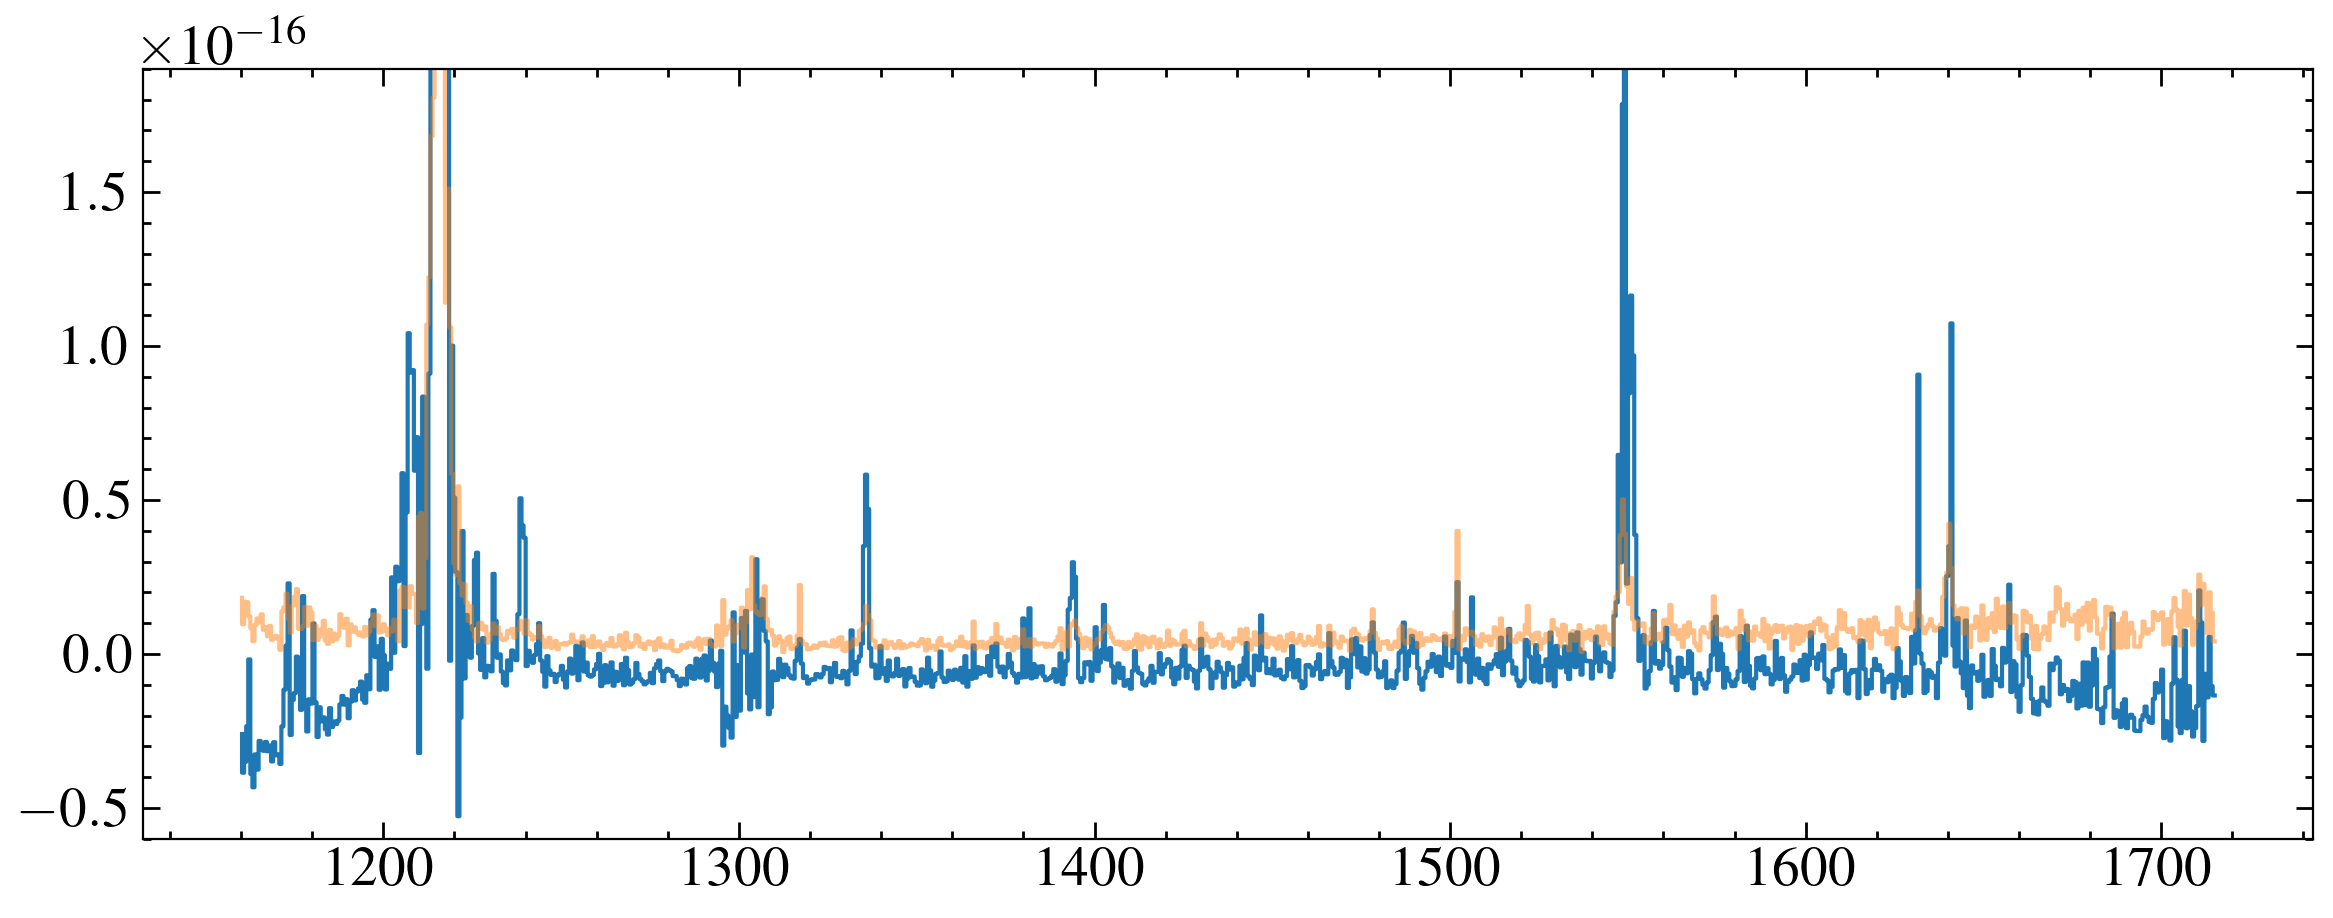

In [19]:
plt.step(w_fuv, f_fuv, label='G140L')
plt.step(w_fuv, e_fuv, alpha=0.5)
# plt.step(w_lya, f_lya, label='G140M')
# plt.step(w_lya, e_lya, label='G140M')

plt.ylim(-0.6e-16, 1.9e-16)

/home/david/work/meats/SEDs/prepare_stis.py:36: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / (e_array**2)
/home/david/anaconda3/envs/stenv/lib/python3.11/site-packages/numpy/lib/function_base.py:553: RuntimeWarning: invalid value encountered in multiply
  avg = avg_as_array = np.multiply(a, wgt,


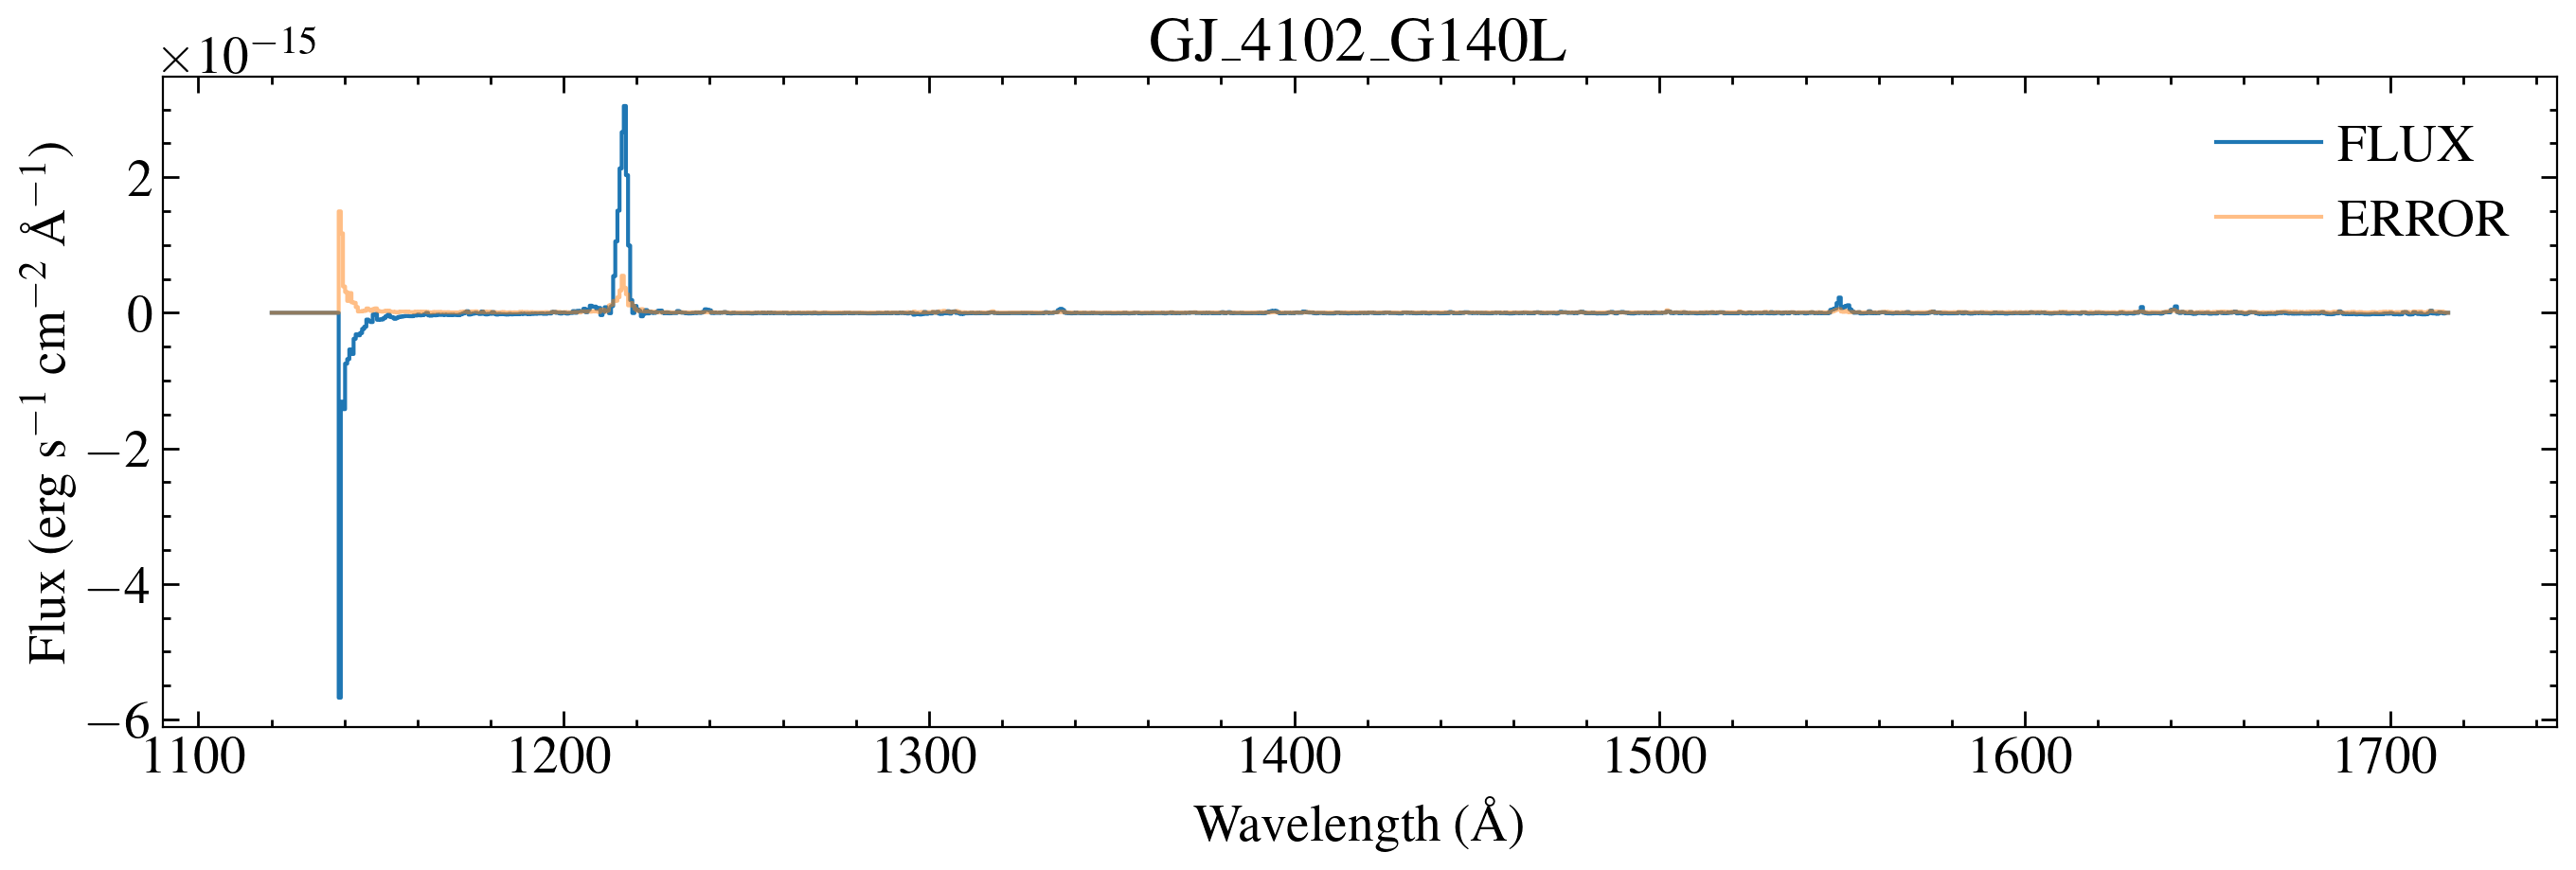

Spectrum saved as hlsp_muscles_hst_stis_gj_4102_g140l_v1_component-spec.fits


/home/david/anaconda3/envs/stenv/lib/python3.11/site-packages/astropy/stats/funcs.py:698: RuntimeWarning: invalid value encountered in sqrt
  [n + 0.5 - np.sqrt(n + 0.25), n + 0.5 + np.sqrt(n + 0.25)]
/home/david/work/meats/SEDs/prepare_stis.py:36: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / (e_array**2)
/home/david/anaconda3/envs/stenv/lib/python3.11/site-packages/numpy/lib/function_base.py:553: RuntimeWarning: invalid value encountered in multiply
  avg = avg_as_array = np.multiply(a, wgt,


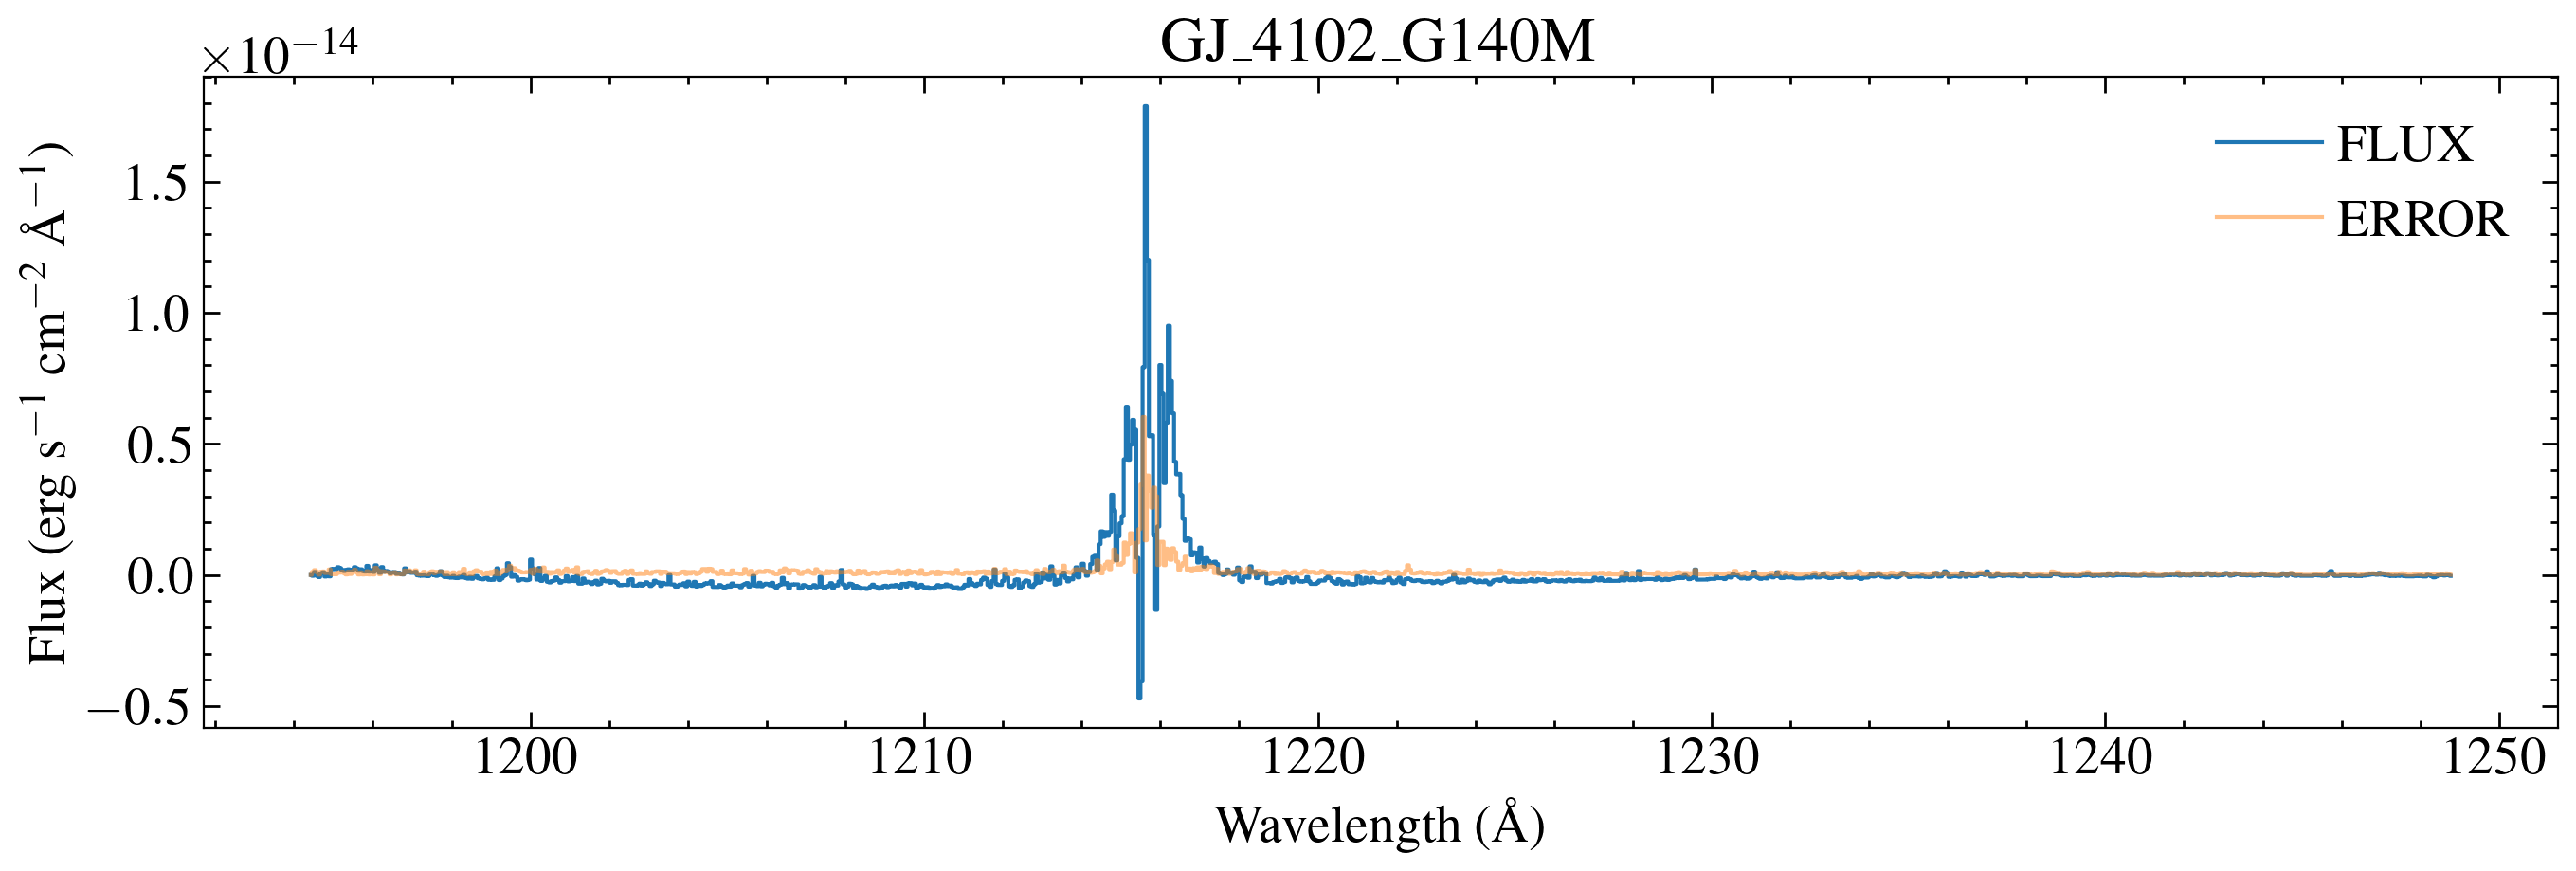

Spectrum saved as hlsp_muscles_hst_stis_gj_4102_g140m_v1_component-spec.fits


/home/david/work/meats/SEDs/prepare_stis.py:36: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / (e_array**2)
/home/david/anaconda3/envs/stenv/lib/python3.11/site-packages/numpy/lib/function_base.py:553: RuntimeWarning: invalid value encountered in multiply
  avg = avg_as_array = np.multiply(a, wgt,


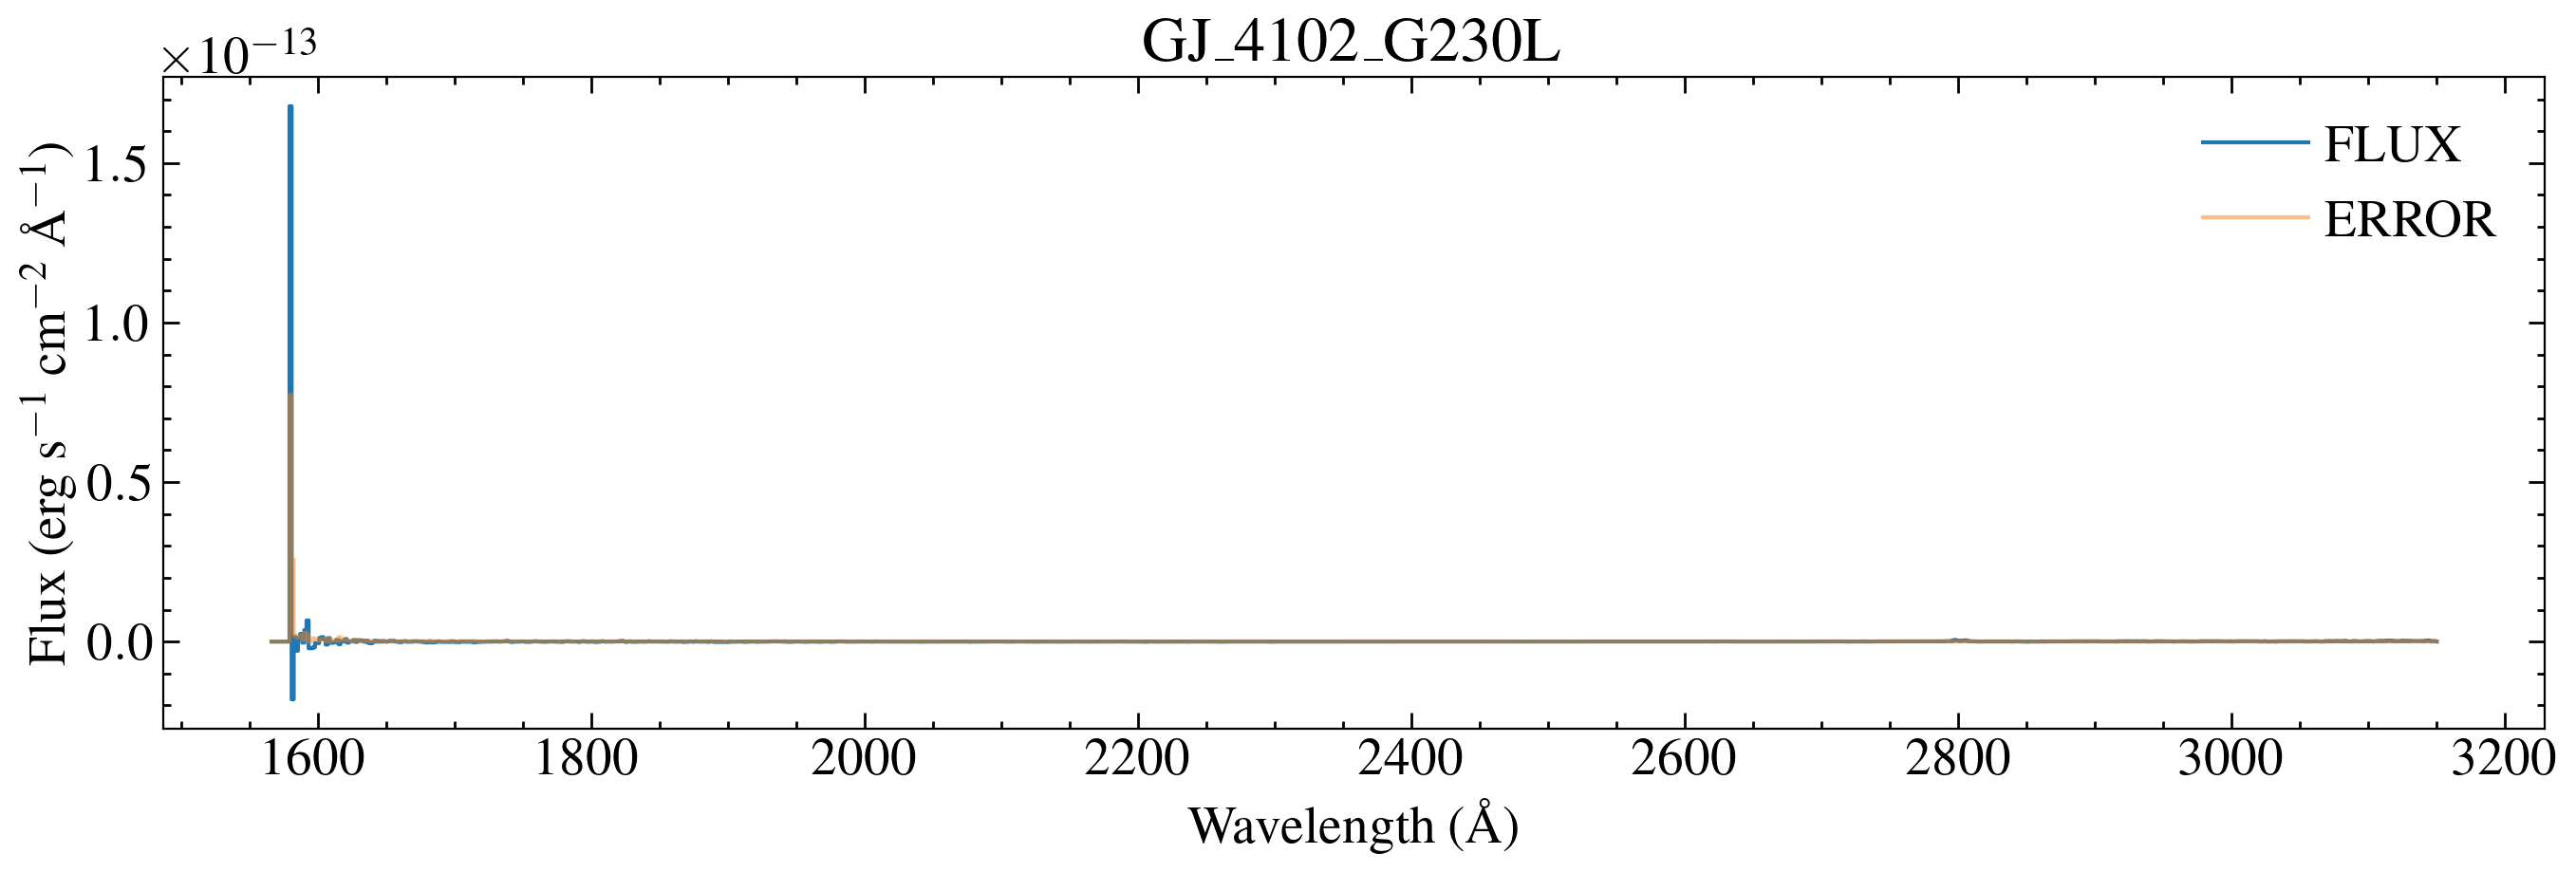

Spectrum saved as hlsp_muscles_hst_stis_gj_4102_g230l_v1_component-spec.fits


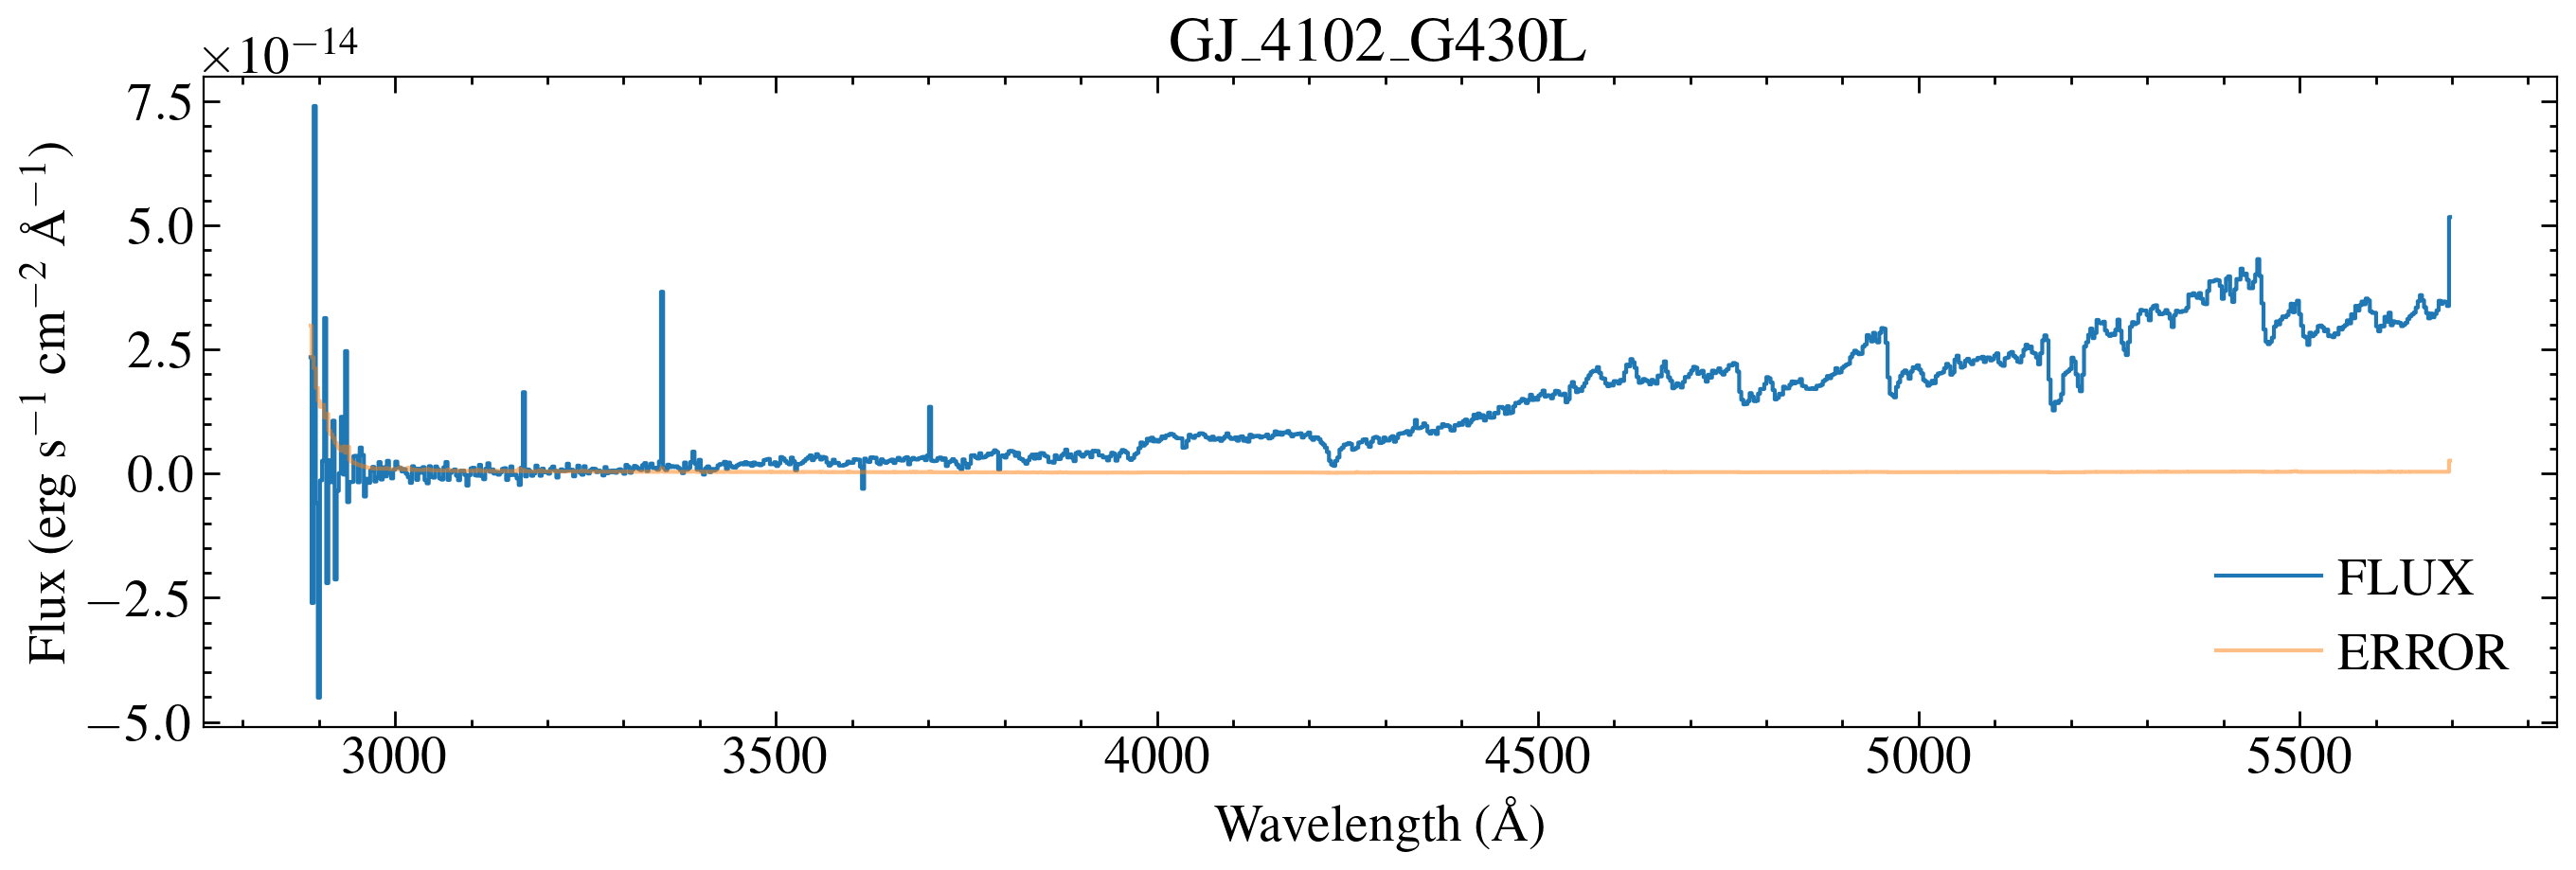

Spectrum saved as hlsp_muscles_hst_stis_gj_4102_g430l_v1_component-spec.fits


In [20]:
import prepare_stis
x1dpath = '/media/david/2tb_ext_hd/hddata/meats/hst/gj4102/used_x1ds/'
savepath = 'draft_hlsp/gj_4102/'
hlsp = 'meats_hlsp_info.csv'
version = 1
prepare_stis.make_stis_spectrum(x1dpath, version, hlsp, savepath = savepath, plot=True, save_fits=True, normfac=1.0, star = 'GJ_4102')